In [1]:
prefix="../../h2o-3"
import sys
sys.path.append(prefix + "/h2o-py/build/main")
import h2o
from h2o.estimators import H2OAdaBoostEstimator, H2OGradientBoostingEstimator
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

versionFromGradle='3.43.0',projectVersion='3.43.0.99999',branch='valenad-6723-adaboost-API',lastCommitHash='d58b1c3ef068a0feec1c49661dd49e9279b33d68',gitDescribe='jenkins-master-6264-18-gd58b1c3ef0',compiledOn='2023-09-11 15:31:47',compiledBy='potte'


In [2]:
# Notebook parameters

seed = 1234
n_estimators = 500
attempt_per_thread = 15 # number of runs of the algorithm in the thread
threds = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [3]:
def train_models(nthreads, file, target):
    h2o.init(nthreads=nthreads)
    train = h2o.import_file(file)
    train[target] = train[target].asfactor()
    global N
    N = train.shape[0]
    global P 
    P = train.shape[1]
    start = time.time()
    adaBoost_h2o = H2OAdaBoostEstimator(model_id = "adaboost.hex",
                                         n_estimators = n_estimators, seed = seed)
    adaBoost_h2o.train(training_frame = train, y=target)
    end = time.time()
    adaboost_time = end - start
    print(f"AdaBoost Time: {adaboost_time}s")
    start = time.time()
    gbm_h2o = H2OGradientBoostingEstimator(model_id = "adaboost.hex",
                                         ntrees = n_estimators, max_depth=2, score_tree_interval=n_estimators+1)
    gbm_h2o.train(training_frame = train, y=target)
    end = time.time()
    gbm_time = end - start
    print(f"GBM Time: {gbm_time}s")    
    h2o.cluster().shutdown()
    time.sleep(3)
    return adaboost_time, gbm_time


def run_benchmark(file, target):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        for i in range(attempt_per_thread):
            eif_time, if_time = train_models(nthreads, file, target)
            times_eif.append(eif_time)
            times_if.append(if_time)
        print(f"AdaBoost {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - AdaBoost {np.mean(times_eif)}s and GBM {np.mean(times_if)}s")

    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - AdaBoost = {np.mean(all_times_num_eif[i])}, GBM = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])
    
    return eif_means, if_means
        
    
def plot_result(eif_means, if_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="AdaBoost", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="GBM", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"AdaBoost - training benchmark\nModel: N = {N}; P = {P}; n_estimatos = {n_estimators};")
    plt.savefig(f"h2o-scale-perf_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [4]:
adaboost_time, gbm_time = run_benchmark(prefix + "/smalldata/prostate/prostate.csv", "CAPSULE")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpalsmzuwn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpalsmzuwn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpalsmzuwn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_93wmnb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9572088718414307s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017948627471924s
H2O session _sid_8a67 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt4l4ww3d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt4l4ww3d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt4l4ww3d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ejnkxz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.485001802444458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7013325691223145s
H2O session _sid_be8c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi519fjes
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi519fjes\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi519fjes\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_koi68d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9951558113098145s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7173399925231934s
H2O session _sid_bdac closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyzdu93cj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyzdu93cj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyzdu93cj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_21ep2k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.032323598861694s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6861627101898193s
H2O session _sid_bbde closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpilhxvr8_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpilhxvr8_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpilhxvr8_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8ulsra
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0093092918396s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6857192516326904s
H2O session _sid_8a75 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph837dt2s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph837dt2s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph837dt2s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_z14h59
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.3861100673675537s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017960548400879s
H2O session _sid_95af closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp66xhmiu5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp66xhmiu5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp66xhmiu5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_26h1sg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0936806201934814s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7329745292663574s
H2O session _sid_aba0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw3m3t8z9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw3m3t8z9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw3m3t8z9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tdw0xd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.3608455657958984s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017076015472412s
H2O session _sid_a546 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo09jeuob
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo09jeuob\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo09jeuob\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5z4mi3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.062492609024048s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6796138286590576s
H2O session _sid_93ea closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8k3x3732
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8k3x3732\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8k3x3732\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4u0zan
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.010392189025879s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7014667987823486s
H2O session _sid_aac0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpythdrj_y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpythdrj_y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpythdrj_y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_om1bek
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.010343551635742s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.685899019241333s
H2O session _sid_822e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw4w2vism
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw4w2vism\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw4w2vism\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qns1nw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.010143041610718s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7166914939880371s
H2O session _sid_96e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1z8jb50o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1z8jb50o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1z8jb50o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jw0bql
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.4455273151397705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6858303546905518s
H2O session _sid_a5ce closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxms074em
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxms074em\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxms074em\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_a96ljy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.4704322814941406s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6857824325561523s
H2O session _sid_84d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_e32q2yr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_e32q2yr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_e32q2yr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_s10uem
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.040929079055786s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016947269439697s
H2O session _sid_b00d closed.
AdaBoost 3.8246597131093343s
IF 0.6990537484486897s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpse_db8aj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpse_db8aj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpse_db8aj\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c148fe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.017427444458008s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.9424245357513428s
H2O session _sid_b987 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdb763_cw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdb763_cw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdb763_cw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mphxq7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.05420708656311s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.71730637550354s
H2O session _sid_814e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphcu_zrmt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphcu_zrmt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphcu_zrmt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_x5j5yp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.053600549697876s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.9021565914154053s
H2O session _sid_9124 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfjr4iagx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfjr4iagx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfjr4iagx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6nwizu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.977435827255249s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6701231002807617s
H2O session _sid_8f71 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb04ns2po
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb04ns2po\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb04ns2po\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_trrsrn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0284202098846436s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016580104827881s
H2O session _sid_b9ed closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw0lyyj2x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw0lyyj2x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw0lyyj2x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_i90k6f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.745053768157959s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.727001428604126s
H2O session _sid_8b70 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpopw7s1kq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpopw7s1kq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpopw7s1kq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_k8xxbe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.004883289337158s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7171130180358887s
H2O session _sid_95a5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe17nofui
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe17nofui\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe17nofui\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p87blg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.090263843536377s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7165312767028809s
H2O session _sid_8304 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpani76k50
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpani76k50\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpani76k50\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jkbkyv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.174927234649658s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7126023769378662s
H2O session _sid_a547 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprr4joubi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprr4joubi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprr4joubi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lpb23f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.790504693984985s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.9022760391235352s
H2O session _sid_94b4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb9qtabyp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb9qtabyp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb9qtabyp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ypfhe0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.979881525039673s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7166998386383057s
H2O session _sid_a4b6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpec4xvozk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpec4xvozk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpec4xvozk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ebaezm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.638930320739746s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.9176685810089111s
H2O session _sid_ada9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppqgztqh1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppqgztqh1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppqgztqh1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_id54d0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.100572824478149s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017331123352051s
H2O session _sid_ae1e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdb6lpnmz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdb6lpnmz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdb6lpnmz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_afdno6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.719528436660767s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017266750335693s
H2O session _sid_a31b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2frqg83r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2frqg83r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2frqg83r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5p9ll2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.993696928024292s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7173254489898682s
H2O session _sid_9c7c closed.
AdaBoost 4.224622265497843s
IF 0.7642897605895996s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0ry79isc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0ry79isc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0ry79isc\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qjulma
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.691117286682129s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7062010765075684s
H2O session _sid_bb48 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3fyld5_n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3fyld5_n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3fyld5_n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_320l19
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.062654495239258s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016842365264893s
H2O session _sid_ad18 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxjk2bbyp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxjk2bbyp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxjk2bbyp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dik6co
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0715155601501465s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6956565380096436s
H2O session _sid_b241 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5m18pi8l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5m18pi8l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5m18pi8l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4x6o8w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9789226055145264s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6858279705047607s
H2O session _sid_98ca closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphjlg15xx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphjlg15xx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphjlg15xx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_65seth
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9946839809417725s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7173876762390137s
H2O session _sid_8acb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt330rw76
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt330rw76\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt330rw76\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hwme1z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.048064231872559s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6857378482818604s
H2O session _sid_9467 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj4qhgg_j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj4qhgg_j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj4qhgg_j\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_fca5c6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.063971519470215s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7014203071594238s
H2O session _sid_93f8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk03fev5g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk03fev5g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk03fev5g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pmn3c9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.025448322296143s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7021152973175049s
H2O session _sid_a08e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx93ryj0m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx93ryj0m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx93ryj0m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kny8xa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.993502140045166s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6860635280609131s
H2O session _sid_9885 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp89fg3_aq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp89fg3_aq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp89fg3_aq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dvrzth
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.3191354274749756s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7018492221832275s
H2O session _sid_a8b2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcuxs9fpc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcuxs9fpc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcuxs9fpc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ui7ht1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.026381969451904s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6861565113067627s
H2O session _sid_ae1d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx50mos6l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx50mos6l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx50mos6l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_i8o514
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9176480770111084s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6952474117279053s
H2O session _sid_887a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxzydvjh0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxzydvjh0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxzydvjh0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ibqk18
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.009641885757446s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7165317535400391s
H2O session _sid_a54d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpptvczzi6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpptvczzi6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpptvczzi6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ng8q6n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.4856138229370117s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017571926116943s
H2O session _sid_8676 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgy9qm5mk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgy9qm5mk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgy9qm5mk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0s2qli
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.063107013702393s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6860873699188232s
H2O session _sid_b9bb closed.
AdaBoost 3.9834272225697833s
IF 0.697981595993042s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1n4eyd5j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1n4eyd5j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1n4eyd5j\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_z209ro
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.979003429412842s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017116546630859s
H2O session _sid_8a61 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphq91_a1k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphq91_a1k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphq91_a1k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_w5ci3l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.00941014289856s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7015354633331299s
H2O session _sid_b750 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpekaevans
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpekaevans\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpekaevans\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_puk077
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.026784658432007s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6860671043395996s
H2O session _sid_8980 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe6twyxrw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe6twyxrw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe6twyxrw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_k4oev4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.025347471237183s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6860990524291992s
H2O session _sid_9c10 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnu4adzyb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnu4adzyb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnu4adzyb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0amcei
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.441596269607544s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6899197101593018s
H2O session _sid_9928 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprmvhas6u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprmvhas6u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprmvhas6u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xrckzu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.658310413360596s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7014057636260986s
H2O session _sid_8d27 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyt_fhqlo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyt_fhqlo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyt_fhqlo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4hu1w9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.97886323928833s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.9221451282501221s
H2O session _sid_8570 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzz2tina5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzz2tina5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzz2tina5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hk8v5s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.062798261642456s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.676389217376709s
H2O session _sid_b70e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbo4k_lgp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbo4k_lgp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbo4k_lgp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_erzwlk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.075269460678101s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7096297740936279s
H2O session _sid_a378 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp74rppe81
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp74rppe81\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp74rppe81\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_50gqgq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.016353607177734s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6860253810882568s
H2O session _sid_9d9b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgdo4g4up
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgdo4g4up\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgdo4g4up\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wp5kld
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9805214405059814s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.70436692237854s
H2O session _sid_9104 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm20tnjyg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm20tnjyg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm20tnjyg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1tmzb3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.028697967529297s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7013516426086426s
H2O session _sid_9422 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgprh0n_7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgprh0n_7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgprh0n_7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pbj1eu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.051806449890137s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7023100852966309s
H2O session _sid_8bfa closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2l3yi9kx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2l3yi9kx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2l3yi9kx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ga2d2a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.1443986892700195s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6893784999847412s
H2O session _sid_971d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_mehy26l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_mehy26l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_mehy26l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_e23tky
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.04100775718689s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6861658096313477s
H2O session _sid_9435 closed.
AdaBoost 4.0346779505411785s
IF 0.7096334139506022s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz9zwo_s1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz9zwo_s1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz9zwo_s1\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lo44zc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.019089937210083s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7014949321746826s
H2O session _sid_bc14 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdtvl8ewc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdtvl8ewc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdtvl8ewc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ok65nh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0594189167022705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6701006889343262s
H2O session _sid_a842 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpweohl1od
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpweohl1od\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpweohl1od\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_icc0hp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.027150392532349s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6858856678009033s
H2O session _sid_ba40 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp55u0uyaz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp55u0uyaz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp55u0uyaz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4gu80u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.011145830154419s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016329765319824s
H2O session _sid_92eb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfm8fv2uo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfm8fv2uo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfm8fv2uo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_e595oq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.042961597442627s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016160488128662s
H2O session _sid_9a05 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1xcdp1hg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1xcdp1hg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1xcdp1hg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_d43sm3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.055963754653931s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016596794128418s
H2O session _sid_9f97 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0f477ktz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0f477ktz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0f477ktz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_084x7o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.107715606689453s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6860659122467041s
H2O session _sid_9bf4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcqsi4ca_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcqsi4ca_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcqsi4ca_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_673dgb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.040495872497559s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6860809326171875s
H2O session _sid_a3b2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvj0diy4a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvj0diy4a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvj0diy4a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nx0x6a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.021947383880615s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017178535461426s
H2O session _sid_a122 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9ku7dsia
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9ku7dsia\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9ku7dsia\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lor98q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.009987831115723s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7012851238250732s
H2O session _sid_95dd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuvzs728l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuvzs728l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuvzs728l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_31g80w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.027056932449341s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5168106555938721s
H2O session _sid_97dc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9r03x1vf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9r03x1vf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9r03x1vf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_t22iw3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9636459350585938s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7013230323791504s
H2O session _sid_b11a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeg4ih666
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeg4ih666\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeg4ih666\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1di3md
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.042187452316284s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7173893451690674s
H2O session _sid_a691 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8v6rig83
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8v6rig83\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8v6rig83\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wdkvr5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.031841278076172s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017426490783691s
H2O session _sid_be8c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsl7n9jaf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsl7n9jaf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsl7n9jaf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jv48ka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.92537260055542s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7014386653900146s
H2O session _sid_887b closed.
AdaBoost 4.025732088088989s
IF 0.6850829442342122s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpva2dvqmm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpva2dvqmm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpva2dvqmm\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_39t16r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9620893001556396s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7169086933135986s
H2O session _sid_bd46 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4s_32cov
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4s_32cov\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4s_32cov\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sl237w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.010714292526245s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017102241516113s
H2O session _sid_8b06 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuhomojzo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuhomojzo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuhomojzo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tlosu1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.3613028526306152s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6860389709472656s
H2O session _sid_9bf8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqyvtdl8v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqyvtdl8v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqyvtdl8v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_f6qdd8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.4696037769317627s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6862485408782959s
H2O session _sid_b873 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb4p_j3xe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb4p_j3xe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb4p_j3xe\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_m3ebqi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.369997024536133s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016763687133789s
H2O session _sid_bf24 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp11a1tnq9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp11a1tnq9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp11a1tnq9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mqwb1z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9638378620147705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6860742568969727s
H2O session _sid_8306 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz33l9nk3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz33l9nk3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz33l9nk3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4p4ocs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9944658279418945s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7014687061309814s
H2O session _sid_b564 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd3w4xxwl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd3w4xxwl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd3w4xxwl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tab9x6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.057604789733887s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7013149261474609s
H2O session _sid_a707 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3alm0cbu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3alm0cbu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3alm0cbu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qlbzba
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.4611358642578125s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6862277984619141s
H2O session _sid_9f89 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprwcx3ujp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprwcx3ujp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprwcx3ujp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_i9zkrb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.962334156036377s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6992535591125488s
H2O session _sid_a7fa closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1q1bigu3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1q1bigu3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1q1bigu3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6e7e6m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9777584075927734s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7175259590148926s
H2O session _sid_9ea7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl5o_7mv_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl5o_7mv_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl5o_7mv_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_n7xy57
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.4858450889587402s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.67041015625s
H2O session _sid_a24d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphc5elkr5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphc5elkr5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphc5elkr5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:/

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tgrzuo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.054231882095337s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6859126091003418s
H2O session _sid_80f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3ryn1bfl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3ryn1bfl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3ryn1bfl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0zqq5r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.024677276611328s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7052838802337646s
H2O session _sid_bab8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy2wwro72
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy2wwro72\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy2wwro72\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c856k4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0117833614349365s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7160899639129639s
H2O session _sid_b437 closed.
AdaBoost 3.81115878423055s
IF 0.697476307551066s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmnm3r99x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmnm3r99x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmnm3r99x\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zikv0q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.02529501914978s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7018001079559326s
H2O session _sid_bbff closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2r78vq4e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2r78vq4e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2r78vq4e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_05ssza
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.044593334197998s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7081959247589111s
H2O session _sid_b82a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp68oax_aw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp68oax_aw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp68oax_aw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gxcgkb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0605762004852295s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7014727592468262s
H2O session _sid_ba26 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0v6n3enb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0v6n3enb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0v6n3enb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3ora89
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.041964769363403s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.703054666519165s
H2O session _sid_8fcc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqor273yw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqor273yw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqor273yw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_z6sk9r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.02258825302124s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7123813629150391s
H2O session _sid_a6e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq0484s5n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq0484s5n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq0484s5n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5femtc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.046725273132324s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7138357162475586s
H2O session _sid_bf50 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq0ip1smz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq0ip1smz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq0ip1smz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2jzn3i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.041134357452393s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7167441844940186s
H2O session _sid_9521 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzz9n28p3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzz9n28p3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzz9n28p3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1maokw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.052605152130127s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7124893665313721s
H2O session _sid_a54c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7fp7ontn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7fp7ontn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7fp7ontn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tu2cu1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0154712200164795s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.9240379333496094s
H2O session _sid_919c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqjyatawb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqjyatawb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqjyatawb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_m6lbu0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.027980089187622s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7173025608062744s
H2O session _sid_b0e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0q2e9rdb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0q2e9rdb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0q2e9rdb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_g5uuaw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.001373052597046s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.733081579208374s
H2O session _sid_bda5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps26xpym_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps26xpym_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps26xpym_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kbey6a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.013490438461304s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6979513168334961s
H2O session _sid_bac2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt17s9qnm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt17s9qnm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt17s9qnm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6isgk9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.850659608840942s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7173435688018799s
H2O session _sid_80ae closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2gky2gu6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2gky2gu6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2gky2gu6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_89p9mz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9445064067840576s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7173318862915039s
H2O session _sid_8310 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdwjoyw2i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdwjoyw2i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdwjoyw2i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vwztb1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.061332941055298s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016661167144775s
H2O session _sid_b31f closed.
AdaBoost 4.083353074391683s
IF 0.7252459367116292s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwmhsqpc_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwmhsqpc_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwmhsqpc_\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_h43eq0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.940579891204834s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6857738494873047s
H2O session _sid_9bd4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4e78w88r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4e78w88r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4e78w88r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o051qj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.010581970214844s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5011935234069824s
H2O session _sid_94a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7kl8mlph
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7kl8mlph\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7kl8mlph\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qmik84
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9936201572418213s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7008006572723389s
H2O session _sid_91a9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppsvdrgzy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppsvdrgzy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppsvdrgzy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wzvn4j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.027063846588135s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7166075706481934s
H2O session _sid_a237 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcvkgef1n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcvkgef1n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcvkgef1n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_z2x7ma
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.3690896034240723s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6703641414642334s
H2O session _sid_a141 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgryhd_pe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgryhd_pe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgryhd_pe\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7t002n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0411505699157715s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6858773231506348s
H2O session _sid_8533 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgrbvm3b5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgrbvm3b5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgrbvm3b5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7yve59
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.025419235229492s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6859700679779053s
H2O session _sid_be2d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_9tssc55
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_9tssc55\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_9tssc55\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9s4t3n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9787065982818604s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6859333515167236s
H2O session _sid_915b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppbzf01vb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppbzf01vb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppbzf01vb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_23kdiv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9863781929016113s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7009406089782715s
H2O session _sid_b46d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxxpo8j3d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxxpo8j3d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxxpo8j3d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_iex0pw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.385901927947998s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7018098831176758s
H2O session _sid_9a49 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8t41ma8x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8t41ma8x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8t41ma8x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_a978ns
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.061464071273804s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7343146800994873s
H2O session _sid_85e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw5ogel0d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw5ogel0d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw5ogel0d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bulvqs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9359474182128906s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6619112491607666s
H2O session _sid_9c22 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp86_lj3__
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp86_lj3__\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp86_lj3__\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gulk2j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.139498472213745s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6745221614837646s
H2O session _sid_9445 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgown9g7z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgown9g7z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgown9g7z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o7r3xe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.123406410217285s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.723820686340332s
H2O session _sid_b62d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa49fiita
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa49fiita\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa49fiita\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jeqrez
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.15443754196167s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6938846111297607s
H2O session _sid_9ffd closed.
AdaBoost 3.9448830604553224s
IF 0.6815816243489583s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplq1vfzs7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplq1vfzs7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplq1vfzs7\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3w69bl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.10456919670105s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016956806182861s
H2O session _sid_b34a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx5p6nyrz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx5p6nyrz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx5p6nyrz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kl3pje
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.060519695281982s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7169716358184814s
H2O session _sid_8ef8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnivsvsf1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnivsvsf1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnivsvsf1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1zz16i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.064509153366089s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7050776481628418s
H2O session _sid_98d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq1591v5s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq1591v5s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq1591v5s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_60gvf9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9874961376190186s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016825675964355s
H2O session _sid_9c0a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph4dou8cx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph4dou8cx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph4dou8cx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2rwudb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.4911789894104004s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6774039268493652s
H2O session _sid_aadb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxyxbybl6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxyxbybl6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxyxbybl6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_i93izs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.981257200241089s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7329506874084473s
H2O session _sid_9e2d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb2ufi947
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb2ufi947\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb2ufi947\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6fijoq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.024822473526001s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6987597942352295s
H2O session _sid_910c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyf2zw9u2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyf2zw9u2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyf2zw9u2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_v6ueg6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.001268148422241s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7082123756408691s
H2O session _sid_93fc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeeauil85
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeeauil85\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeeauil85\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_aglq7s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.01392126083374s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7009291648864746s
H2O session _sid_818a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwrfkv21f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwrfkv21f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwrfkv21f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_q315l3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.989443063735962s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6944730281829834s
H2O session _sid_b626 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3j5z6yv9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3j5z6yv9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3j5z6yv9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vinubs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.056591510772705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6705830097198486s
H2O session _sid_8ec0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpim7cjus_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpim7cjus_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpim7cjus_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kg4hed
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.961785078048706s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7161376476287842s
H2O session _sid_976c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5_qvpu3x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5_qvpu3x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5_qvpu3x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tcz0pg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9332141876220703s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7113065719604492s
H2O session _sid_93a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmq9a8j17
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmq9a8j17\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmq9a8j17\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6bvyjp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.3704257011413574s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6852710247039795s
H2O session _sid_a62d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzzjpf37k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzzjpf37k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzzjpf37k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1kicee
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9102625846862793s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6702215671539307s
H2O session _sid_be86 closed.
AdaBoost 3.930084292093913s
IF 0.6994450887044271s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqhhizv6o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqhhizv6o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqhhizv6o\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lgsf3e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9947686195373535s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016661167144775s
H2O session _sid_bce5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp92jfnkwp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp92jfnkwp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp92jfnkwp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_fcrd93
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9731905460357666s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017042636871338s
H2O session _sid_a30b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe3nahare
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe3nahare\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe3nahare\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xnj41h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.3859801292419434s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017519474029541s
H2O session _sid_a939 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4gih4u4b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4gih4u4b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4gih4u4b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_d0c45l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.048115253448486s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7017045021057129s
H2O session _sid_a045 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsa006shr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsa006shr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsa006shr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5lqkv5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.032453536987305s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6968662738800049s
H2O session _sid_a7d5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1227kx4y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1227kx4y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1227kx4y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0g7ix2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.4612338542938232s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6858246326446533s
H2O session _sid_bedf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuk3jq0ym
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuk3jq0ym\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuk3jq0ym\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lffygb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.3760385513305664s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6951797008514404s
H2O session _sid_b6c0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1ipxapwo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1ipxapwo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1ipxapwo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7szu49
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.391873598098755s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016987800598145s
H2O session _sid_a2e3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp05t7zjz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp05t7zjz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp05t7zjz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p1llj1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.049437761306763s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7016961574554443s
H2O session _sid_8fe3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp81zfxuim
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp81zfxuim\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp81zfxuim\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xydx2v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9952054023742676s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6861014366149902s
H2O session _sid_aebc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj11snp_h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj11snp_h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj11snp_h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4vsnhs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9569640159606934s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6865518093109131s
H2O session _sid_acba closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpentz8sl5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpentz8sl5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpentz8sl5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_s4d0nt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.021713972091675s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7244036197662354s
H2O session _sid_b537 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp24c7dvla
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp24c7dvla\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp24c7dvla\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_x2z6fu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.016985893249512s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.698552131652832s
H2O session _sid_9879 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2hi7n77w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2hi7n77w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2hi7n77w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_auod06
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.870988368988037s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6773815155029297s
H2O session _sid_ac2c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzoz9w70w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzoz9w70w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzoz9w70w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mqfbkg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.083070278167725s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7172398567199707s
H2O session _sid_b379 closed.
AdaBoost 3.910534652074178s
IF 0.6985548496246338s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgia9gzf8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgia9gzf8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgia9gzf8\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_eyglun
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.046389102935791s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7169985771179199s
H2O session _sid_ba1e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpikena1qq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpikena1qq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpikena1qq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_g7lafb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.085007190704346s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7192952632904053s
H2O session _sid_bbd0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt1dr2ypv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt1dr2ypv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt1dr2ypv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_42tz7t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.172595739364624s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6929585933685303s
H2O session _sid_acaf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1f94slyb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1f94slyb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1f94slyb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_b61cat
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.09592604637146s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.689464807510376s
H2O session _sid_9df3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5709dzsq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5709dzsq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5709dzsq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vnw9jb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.040220022201538s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7038764953613281s
H2O session _sid_8b06 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnb9x9xhg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnb9x9xhg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnb9x9xhg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_54iuuz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.007664680480957s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7030255794525146s
H2O session _sid_ab54 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5gzrfgj7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5gzrfgj7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5gzrfgj7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1faplz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.010847330093384s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7083258628845215s
H2O session _sid_b9ec closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoxlhw8wt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoxlhw8wt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoxlhw8wt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tiasms
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.107343912124634s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6837093830108643s
H2O session _sid_9fab closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp43_betey
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp43_betey\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp43_betey\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ehzjdy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.031501054763794s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6922006607055664s
H2O session _sid_93bd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5762wr8y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5762wr8y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5762wr8y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wjmrzo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.636004686355591s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7003493309020996s
H2O session _sid_b28b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl2ga6w4f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl2ga6w4f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl2ga6w4f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2cdtkf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.097857236862183s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7027876377105713s
H2O session _sid_a9be closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmply9_rbwk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmply9_rbwk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmply9_rbwk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5xncr2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.4074044227600098s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6939146518707275s
H2O session _sid_96b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb4ot09wd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb4ot09wd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb4ot09wd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3g34vx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.624414443969727s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6828958988189697s
H2O session _sid_ae9b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzlsj901c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzlsj901c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzlsj901c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kre48i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0459606647491455s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.695594310760498s
H2O session _sid_9cf2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpajqp9fp8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpajqp9fp8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpajqp9fp8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4v9vni
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.104747772216797s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4929971694946289s
H2O session _sid_8f9d closed.
AdaBoost 4.100925620396932s
IF 0.6852262814839681s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7bmcvgj4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7bmcvgj4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7bmcvgj4\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8zspet
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.078587055206299s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7102296352386475s
H2O session _sid_b29c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr464622c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr464622c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr464622c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lb9qae
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.042849540710449s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.682375431060791s
H2O session _sid_8ca2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqmoz2cvh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqmoz2cvh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqmoz2cvh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vs11yv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.117336750030518s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6791970729827881s
H2O session _sid_a595 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbfh0cu0b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbfh0cu0b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbfh0cu0b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_oqr6vg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.1406660079956055s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6982028484344482s
H2O session _sid_99f1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw6w56ohe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw6w56ohe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw6w56ohe\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_t6mw46
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9303319454193115s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6889915466308594s
H2O session _sid_84e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7m7frioz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7m7frioz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7m7frioz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lumsep
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.072957277297974s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6771245002746582s
H2O session _sid_9fc0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgvozo03r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgvozo03r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgvozo03r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7tx6qe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.011151552200317s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7346115112304688s
H2O session _sid_b97f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpablbodq0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpablbodq0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpablbodq0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5ceht4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.991530179977417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7048780918121338s
H2O session _sid_91c3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkt20ao9k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkt20ao9k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkt20ao9k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ioypw6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.038846254348755s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7153339385986328s
H2O session _sid_bd63 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx0zd_l5_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx0zd_l5_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx0zd_l5_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_38nzzm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0514490604400635s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.4855790138244629s
H2O session _sid_823e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe0n8h2of
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe0n8h2of\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe0n8h2of\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pet35s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.001569747924805s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6878085136413574s
H2O session _sid_81cf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcjb1e3w4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcjb1e3w4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcjb1e3w4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_x76oeq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.088110685348511s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6829593181610107s
H2O session _sid_8291 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6l8mj_9h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6l8mj_9h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6l8mj_9h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6pnwvi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.970961570739746s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.717310905456543s
H2O session _sid_b3ba closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5012v4ao
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5012v4ao\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5012v4ao\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_our4xy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.069862604141235s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.6997332572937012s
H2O session _sid_84bd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyrf1_ccn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyrf1_ccn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyrf1_ccn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_68tza1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.9500865936279297s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.7173748016357422s
H2O session _sid_bdfd closed.
AdaBoost 4.0370864550272625s
IF 0.685447359085083s
12 - AdaBoost = 3.8246597131093343, GBM = 0.6990537484486897
11 - AdaBoost = 4.224622265497843, GBM = 0.7642897605895996
10 - AdaBoost = 3.9834272225697833, GBM = 0.697981595993042
9 - AdaBoost = 4.0346779505411785, GBM = 0.7096334139506022
8 - AdaBoost = 4.025732088088989, GBM = 0.6850829442342122
7 - AdaBoost = 3.81115878423055, GBM = 0.697476307551066
6 - AdaBoost = 4.083353074391683, GBM = 0.7252459367116292
5 - AdaBoost = 3.9448830604553224, GBM = 0.6815816243489583
4 - AdaBoost = 3.930084292093913, GBM = 0.6994450887044271
3 - AdaBoost = 3.910534652074178, 

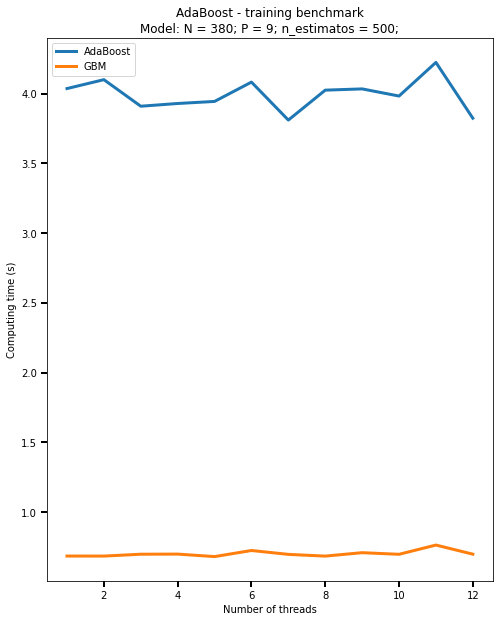

In [5]:
plot_result(adaboost_time, gbm_time)

In [6]:
adaboost_time, gbm_time = run_benchmark(prefix + "/bigdata/laptop/higgs_head_2M.csv", "C1")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpausr4oql
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpausr4oql\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpausr4oql\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hekb7r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 115.55516648292542s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 87.22845983505249s
H2O session _sid_b1c4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdhqucxyt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdhqucxyt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdhqucxyt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c5f4hi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 115.89424586296082s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 88.80089974403381s
H2O session _sid_af5e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdjjikye0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdjjikye0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdjjikye0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1m3m3c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 118.11488628387451s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 84.93579602241516s
H2O session _sid_bcc4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprknadp5g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprknadp5g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprknadp5g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_icowx1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 116.39887523651123s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 85.38745927810669s
H2O session _sid_a796 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpieygyqn2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpieygyqn2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpieygyqn2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_io867s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 119.1370894908905s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 85.6715304851532s
H2O session _sid_abba closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpch_ejmd_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpch_ejmd_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpch_ejmd_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tgl3va
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.91830515861511s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 86.60543441772461s
H2O session _sid_8802 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0ea80yr4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0ea80yr4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0ea80yr4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_h8vt87
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 118.01871728897095s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 90.06775307655334s
H2O session _sid_9ab1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4_t0x7o2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4_t0x7o2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4_t0x7o2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_a5somt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 127.69917726516724s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 84.13193440437317s
H2O session _sid_8815 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxa_788qu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxa_788qu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxa_788qu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_h8i1tp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.71754789352417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 88.03726434707642s
H2O session _sid_b3c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiv42mdlt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiv42mdlt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiv42mdlt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kqblh4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 120.41008615493774s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 85.48911571502686s
H2O session _sid_bf19 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0ze4jmhq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0ze4jmhq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0ze4jmhq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7zw0df
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.63386869430542s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 87.64816641807556s
H2O session _sid_9427 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp74msenjf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp74msenjf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp74msenjf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_80ctm8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 112.19205021858215s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 81.66933107376099s
H2O session _sid_9934 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbddku2ei
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbddku2ei\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbddku2ei\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jy4az0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 115.89458751678467s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 87.65978074073792s
H2O session _sid_99b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphluw5pl2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphluw5pl2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphluw5pl2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nw65h1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 122.26124739646912s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 87.03291654586792s
H2O session _sid_9318 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpksbu_v_2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpksbu_v_2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpksbu_v_2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kxglni
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.77123236656189s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 91.0484824180603s
H2O session _sid_956d closed.
AdaBoost 118.17447222073874s
IF 86.76095496813456s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl_gj2eak
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl_gj2eak\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl_gj2eak\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_x7a4x5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 125.70218682289124s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 94.39556622505188s
H2O session _sid_b012 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps47gqr2s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps47gqr2s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps47gqr2s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zgbcet
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 126.60480117797852s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 92.84425973892212s
H2O session _sid_b142 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbh9ub1qt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbh9ub1qt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbh9ub1qt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_x9d456
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 116.47211074829102s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 89.12839889526367s
H2O session _sid_aff1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptqaerlpy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptqaerlpy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptqaerlpy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2d8j3b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 132.95040822029114s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 93.72596955299377s
H2O session _sid_b50f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7oh3ds98
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7oh3ds98\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7oh3ds98\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ahsl3r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 126.48072934150696s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 90.39745378494263s
H2O session _sid_bc71 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg0gdxkel
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg0gdxkel\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg0gdxkel\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c5q3ey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 124.45012879371643s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 93.59335970878601s
H2O session _sid_9287 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5yy_2tb4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5yy_2tb4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5yy_2tb4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wc7i29
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 124.25725030899048s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 94.24019861221313s
H2O session _sid_93c4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwacu_ajy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwacu_ajy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwacu_ajy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9q3pdt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 119.3014783859253s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 88.06284809112549s
H2O session _sid_a897 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyropn2ry
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyropn2ry\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyropn2ry\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_fs0zfc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.97397422790527s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 83.91801810264587s
H2O session _sid_8489 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaxyat777
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaxyat777\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaxyat777\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_titz39
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 116.49294328689575s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 87.15614199638367s
H2O session _sid_aa33 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc3qkumzw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc3qkumzw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc3qkumzw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uja4og
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 129.23424005508423s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 93.38855862617493s
H2O session _sid_856a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuhvl0nlx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuhvl0nlx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuhvl0nlx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xgm8h3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 134.5607762336731s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 94.22940111160278s
H2O session _sid_8017 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv_g3h236
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv_g3h236\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv_g3h236\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_quwmd9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 129.62683248519897s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 95.18199229240417s
H2O session _sid_b66b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmvfdzw9m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmvfdzw9m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmvfdzw9m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_30m54d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 126.17422199249268s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 92.88305425643921s
H2O session _sid_bb4e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7u42imvv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7u42imvv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7u42imvv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_clos50
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 125.25211668014526s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 88.96186399459839s
H2O session _sid_80d3 closed.
AdaBoost 125.03561325073242s
IF 91.47380566596985s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplwgqub8v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplwgqub8v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplwgqub8v\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_yzflx2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.18247842788696s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 87.53974342346191s
H2O session _sid_bc9f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplg1l_l22
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplg1l_l22\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplg1l_l22\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hbduvn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.08888912200928s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 86.08999609947205s
H2O session _sid_b2ac closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4twgksvc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4twgksvc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4twgksvc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_e2ryre
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 123.18308734893799s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 95.93895149230957s
H2O session _sid_ad1a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcp684scf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcp684scf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcp684scf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ukwvh9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 128.68962025642395s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 93.92626953125s
H2O session _sid_a9e0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd64fendf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd64fendf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd64fendf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_21nckx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 126.39203953742981s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 95.58794903755188s
H2O session _sid_b0b4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn4kb32zl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn4kb32zl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn4kb32zl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lojoxu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 116.9843213558197s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 89.64126014709473s
H2O session _sid_ba0a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt19we5s1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt19we5s1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt19we5s1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bavb8e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 126.40982127189636s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 95.81920623779297s
H2O session _sid_9bcf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp517wrlez
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp517wrlez\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp517wrlez\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_goj34x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 127.73852968215942s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 95.11146235466003s
H2O session _sid_af0f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxd8sw2v0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxd8sw2v0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxd8sw2v0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_oeq2rb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 127.34327816963196s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 87.16693139076233s
H2O session _sid_b62d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdsv6p1r1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdsv6p1r1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdsv6p1r1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hg13at
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 121.04967880249023s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 99.64217185974121s
H2O session _sid_8348 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp86wibor9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp86wibor9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp86wibor9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ai8k1z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 125.9676525592804s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 95.60832118988037s
H2O session _sid_b17f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpugwgn10i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpugwgn10i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpugwgn10i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_opmtjm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 125.39840793609619s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 95.74781847000122s
H2O session _sid_b07a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgdgu50qh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgdgu50qh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgdgu50qh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7xhsxe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 118.84360218048096s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 88.2673966884613s
H2O session _sid_8b3d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6g4oze3n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6g4oze3n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6g4oze3n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gjavnu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 116.5998146533966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 88.2915153503418s
H2O session _sid_a642 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg82pvxb7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg82pvxb7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg82pvxb7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c6wwwv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.2371609210968s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 88.4370334148407s
H2O session _sid_8c00 closed.
AdaBoost 122.4072254816691s
IF 92.18773511250814s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyt89mi06
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyt89mi06\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyt89mi06\h2o_potte_started_from_python.err
  Server is running at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gz3tn8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.90342044830322s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 88.47470355033875s
H2O session _sid_8d11 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxy1qcr5v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxy1qcr5v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxy1qcr5v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mltr4i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 132.65316486358643s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 98.79318928718567s
H2O session _sid_ac95 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8v2pp4ad
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8v2pp4ad\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8v2pp4ad\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uwsa2z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 129.27510261535645s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 97.3259642124176s
H2O session _sid_b5f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdeykjr59
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdeykjr59\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdeykjr59\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4fc4wu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 126.22044610977173s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 89.55257320404053s
H2O session _sid_9189 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_i9i1sz8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_i9i1sz8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_i9i1sz8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8h9nim
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 118.3751494884491s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 89.38819718360901s
H2O session _sid_829a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_g8c0wch
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_g8c0wch\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_g8c0wch\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6qzdnk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 133.64776849746704s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 96.64962792396545s
H2O session _sid_84f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpokln01_r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpokln01_r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpokln01_r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6cxyjs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 130.56085634231567s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 97.62032699584961s
H2O session _sid_8364 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7dlxr2aj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7dlxr2aj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7dlxr2aj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u0l51q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 125.97268319129944s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 89.27114939689636s
H2O session _sid_9e9f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpumw912nc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpumw912nc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpumw912nc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wpiqn3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 120.3583562374115s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 90.71550679206848s
H2O session _sid_9f2c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwn9ogmv8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwn9ogmv8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwn9ogmv8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_v3ff5a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 130.27674889564514s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 97.48577666282654s
H2O session _sid_899e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoowbdg1b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoowbdg1b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoowbdg1b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1ox9di
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 126.92880892753601s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 96.60974168777466s
H2O session _sid_ba2f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplrfqxia8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplrfqxia8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplrfqxia8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6ivuf6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 140.50923013687134s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 100.00220155715942s
H2O session _sid_8081 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphwti3pgk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphwti3pgk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphwti3pgk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_evlsb2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 126.64291667938232s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 98.30039501190186s
H2O session _sid_affa closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3u8upgws
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3u8upgws\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3u8upgws\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_93dmit
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 127.37024021148682s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 94.74086833000183s
H2O session _sid_b1d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpay_cx8n2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpay_cx8n2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpay_cx8n2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zegtgg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 118.9553062915802s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 89.50565385818481s
H2O session _sid_8f0d closed.
AdaBoost 127.04334659576416s
IF 94.29572504361471s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8bz1dt09
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8bz1dt09\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8bz1dt09\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_j2tlb8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 117.57021188735962s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 89.4449257850647s
H2O session _sid_969c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp71mimd_x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp71mimd_x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp71mimd_x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0n1g8h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 134.2798295021057s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 100.56968665122986s
H2O session _sid_9e42 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd7y6koyi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd7y6koyi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd7y6koyi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_68rv59
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 133.32859468460083s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 99.70219683647156s
H2O session _sid_b55d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu4j6603w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu4j6603w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu4j6603w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3qllzo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 127.72300386428833s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 90.87965250015259s
H2O session _sid_b112 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3d8wi_ty
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3d8wi_ty\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3d8wi_ty\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kjh53b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 121.38514637947083s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 104.41333079338074s
H2O session _sid_b637 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm_b9by8w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm_b9by8w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm_b9by8w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mkyxnf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 131.68599557876587s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 97.53296113014221s
H2O session _sid_bae5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfnwnq9aq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfnwnq9aq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfnwnq9aq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_eexk35
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 133.59703922271729s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 102.83574676513672s
H2O session _sid_9069 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv_7cye6e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv_7cye6e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv_7cye6e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_53g4yy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 133.90142250061035s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 100.65424180030823s
H2O session _sid_8c37 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx3ascht4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx3ascht4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx3ascht4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_b3ybdt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 132.50307607650757s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 94.88694357872009s
H2O session _sid_b165 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnosj3uu5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnosj3uu5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnosj3uu5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bzfmuo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 118.48157501220703s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 89.4999783039093s
H2O session _sid_b8b9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsd4n75gp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsd4n75gp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsd4n75gp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8dgw96
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 122.27870464324951s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 107.93057823181152s
H2O session _sid_958b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpczba8h2t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpczba8h2t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpczba8h2t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_54himr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 130.42588448524475s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 99.72808766365051s
H2O session _sid_a5cf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5xx8p6so
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5xx8p6so\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5xx8p6so\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_a0o7qh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 132.79387092590332s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 95.37390160560608s
H2O session _sid_9f77 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnwnsap74
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnwnsap74\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnwnsap74\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lwnozp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 129.90974950790405s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 91.66863441467285s
H2O session _sid_9fa2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp13tvma2g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp13tvma2g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp13tvma2g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_l9wkkf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 118.3777551651001s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 89.62315487861633s
H2O session _sid_a8d9 closed.
AdaBoost 127.882790629069s
IF 96.98293472925822s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpru6yliew
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpru6yliew\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpru6yliew\h2o_potte_started_from_python.err
  Server is running at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_n4pg73
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 146.1667046546936s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 102.85969948768616s
H2O session _sid_8cac closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt4dqu73c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt4dqu73c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt4dqu73c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u4xjq8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 134.71412253379822s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 105.73997521400452s
H2O session _sid_a338 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphmn34vjm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphmn34vjm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphmn34vjm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_31lug0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 128.52136206626892s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 91.52109909057617s
H2O session _sid_bd04 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1o5yzjxo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1o5yzjxo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1o5yzjxo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4u1z50
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 125.26480841636658s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 103.73040890693665s
H2O session _sid_913a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr6avrahu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr6avrahu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr6avrahu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tnr0dv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 135.98747324943542s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 103.18743968009949s
H2O session _sid_be2b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp60qltvu8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp60qltvu8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp60qltvu8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_k2i7no
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 146.6995882987976s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 96.89406561851501s
H2O session _sid_a5a0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuafx67rl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuafx67rl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuafx67rl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mbik7a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 122.17187690734863s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 93.86329460144043s
H2O session _sid_84a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkoefwkmm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkoefwkmm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkoefwkmm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_b8d97o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 138.18648552894592s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 103.25270533561707s
H2O session _sid_adf3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphxz83tlv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphxz83tlv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphxz83tlv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vygvyd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 135.5943148136139s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 103.84651780128479s
H2O session _sid_a1ad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaui_yk99
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaui_yk99\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaui_yk99\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pekgsl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 147.53894662857056s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 102.06077575683594s
H2O session _sid_9514 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzk1jqs61
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzk1jqs61\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzk1jqs61\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_193vj5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 135.01549649238586s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 104.26855945587158s
H2O session _sid_b593 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk26p7znp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk26p7znp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk26p7znp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sviaa0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 130.39986634254456s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 90.69672060012817s
H2O session _sid_a03a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4cmmfztu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4cmmfztu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4cmmfztu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3ksajh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 124.32771897315979s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 90.74710488319397s
H2O session _sid_bb4e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7kuqudlm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7kuqudlm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7kuqudlm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tmtg7b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 121.7283046245575s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 102.23410177230835s
H2O session _sid_89c6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppzdowbuj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppzdowbuj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppzdowbuj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ok1ma4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 131.0622043609619s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 103.97400045394897s
H2O session _sid_8b26 closed.
AdaBoost 133.55861825942992s
IF 99.92509791056315s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9fgs9dfq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9fgs9dfq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9fgs9dfq\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tl5f1m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 140.5482726097107s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 106.78590941429138s
H2O session _sid_8ed8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl60fmtzx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl60fmtzx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl60fmtzx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1n2y6i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 125.17570996284485s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 92.85540914535522s
H2O session _sid_a25a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfhudcs5n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfhudcs5n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfhudcs5n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_r9ez3i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 138.9635980129242s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 106.55474972724915s
H2O session _sid_89e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpje2cdxqp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpje2cdxqp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpje2cdxqp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_il5db6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 140.39820265769958s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 107.63892078399658s
H2O session _sid_ae24 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_nbuky2i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_nbuky2i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_nbuky2i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_e2yw5l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 143.57615637779236s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 93.9649064540863s
H2O session _sid_837c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplzk78cul
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplzk78cul\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplzk78cul\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tkrf44
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 138.88660192489624s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 104.21227073669434s
H2O session _sid_9538 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1icyx1tc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1icyx1tc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1icyx1tc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xt8569
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 140.3262219429016s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 106.2663927078247s
H2O session _sid_8339 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxgij2arn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxgij2arn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxgij2arn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3ea27g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 129.49556159973145s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 104.0844337940216s
H2O session _sid_9267 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfvoxfdle
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfvoxfdle\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfvoxfdle\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qc3gck
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 141.72111988067627s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 109.89603090286255s
H2O session _sid_ad4c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu5asd3gf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu5asd3gf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu5asd3gf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vddwhu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 152.7934112548828s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 104.33365607261658s
H2O session _sid_8745 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaizvd0sb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaizvd0sb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaizvd0sb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mtt8hp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 136.8469910621643s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 100.73372006416321s
H2O session _sid_b536 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphvbp2dtf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphvbp2dtf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphvbp2dtf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_j5n7i5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 142.317232131958s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 106.59928107261658s
H2O session _sid_9431 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt7c6f60m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt7c6f60m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt7c6f60m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jy35lx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 142.5040204524994s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 106.87821674346924s
H2O session _sid_ad66 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxxpxg2_y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxxpxg2_y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxxpxg2_y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1mx5pm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 130.93259978294373s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 95.29222798347473s
H2O session _sid_a7d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfsmk8v97
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfsmk8v97\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfsmk8v97\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_if0dze
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 137.54150104522705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 94.09372043609619s
H2O session _sid_a1c6 closed.
AdaBoost 138.80181337992352s
IF 102.67932306925455s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp80192bmf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp80192bmf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp80192bmf\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zpf7nh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 149.19393610954285s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 112.84305834770203s
H2O session _sid_aecd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcciflqlb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcciflqlb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcciflqlb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4vl8c0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 151.7091145515442s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 112.10659527778625s
H2O session _sid_8235 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn5kasrc_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn5kasrc_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn5kasrc_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qtjvpk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 142.45328545570374s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 103.0782618522644s
H2O session _sid_8141 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmukg5cqd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmukg5cqd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmukg5cqd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pc5yhq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 145.06904077529907s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 113.3997061252594s
H2O session _sid_8639 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxmpfhqv9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxmpfhqv9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxmpfhqv9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_n3kxpq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 148.0009481906891s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 111.82103085517883s
H2O session _sid_8f8e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzpp8fqc9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzpp8fqc9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzpp8fqc9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_v3lw92
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 143.44943809509277s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 113.80427861213684s
H2O session _sid_ac49 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps82ms0dz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps82ms0dz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps82ms0dz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7dwf5r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 148.96773719787598s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 113.05963015556335s
H2O session _sid_a23a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3zcp_ott
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3zcp_ott\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3zcp_ott\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_f3a47z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 144.48060512542725s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 103.16727805137634s
H2O session _sid_ba74 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1o2p4sx_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1o2p4sx_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1o2p4sx_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zpc9pc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 137.38071274757385s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 101.9837794303894s
H2O session _sid_940c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr7jtdj2l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr7jtdj2l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr7jtdj2l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u2lpz8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 137.3166515827179s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 113.75296330451965s
H2O session _sid_8262 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_332eiej
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_332eiej\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_332eiej\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ipx1x1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 151.4621934890747s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 111.13073301315308s
H2O session _sid_b51a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqtuba91r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqtuba91r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqtuba91r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_17db4o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 145.8485345840454s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 106.8916563987732s
H2O session _sid_a5a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb1psb3vg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb1psb3vg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb1psb3vg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ylr9jw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 132.88336086273193s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 106.77766299247742s
H2O session _sid_b9db closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5qb94hjg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5qb94hjg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5qb94hjg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9my1e9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 153.63809609413147s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 112.10028266906738s
H2O session _sid_998b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuieycff4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuieycff4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuieycff4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5ln3zo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 150.51265668869019s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 110.50105357170105s
H2O session _sid_84be closed.
AdaBoost 145.49108743667603s
IF 109.76119804382324s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptde3owip
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptde3owip\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptde3owip\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vzyv3b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 148.08316493034363s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 122.61078929901123s
H2O session _sid_b0d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4u9vlfcb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4u9vlfcb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4u9vlfcb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kzkn9f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 161.74611711502075s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 125.86221075057983s
H2O session _sid_a9e3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbtgog6hl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbtgog6hl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbtgog6hl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_h1kbnq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 164.78991651535034s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 125.7281403541565s
H2O session _sid_8299 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf43185u0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf43185u0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf43185u0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_s1nddc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 161.7448480129242s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 124.35296535491943s
H2O session _sid_8277 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpppksb3kr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpppksb3kr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpppksb3kr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jvg36y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 163.81030011177063s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 121.60263705253601s
H2O session _sid_a76f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwbjdpzyi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwbjdpzyi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwbjdpzyi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vy0dgy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 149.0577037334442s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 119.61842012405396s
H2O session _sid_8543 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1bbkip03
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1bbkip03\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1bbkip03\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wxm48r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 148.42442202568054s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 128.7824501991272s
H2O session _sid_ad91 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk64ze_29
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk64ze_29\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk64ze_29\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_cp3bq3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 159.6698498725891s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 126.68904209136963s
H2O session _sid_a5f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpttlmchq9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpttlmchq9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpttlmchq9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dwu1v4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 162.56185817718506s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 116.60862588882446s
H2O session _sid_9407 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeolf9tfg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeolf9tfg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeolf9tfg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9a25g9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 156.28068804740906s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 125.99091601371765s
H2O session _sid_8e13 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp99jx_cqb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp99jx_cqb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp99jx_cqb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xm7joh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 160.5426425933838s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 127.75659847259521s
H2O session _sid_a2b2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgyc2lb5i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgyc2lb5i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgyc2lb5i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dwrf7m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 155.73843717575073s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 116.67616724967957s
H2O session _sid_8eb1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkk8lf5xe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkk8lf5xe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkk8lf5xe\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ptvme4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 156.4448266029358s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 124.7949206829071s
H2O session _sid_b163 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0oj3ea06
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0oj3ea06\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0oj3ea06\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5k3gl3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 159.099054813385s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 126.53677368164062s
H2O session _sid_aea4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu0ba1zb7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu0ba1zb7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu0ba1zb7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_eon3gt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 166.71774172782898s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 129.90246987342834s
H2O session _sid_866f closed.
AdaBoost 158.3141047636668s
IF 124.23420847256979s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaoa6inr1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaoa6inr1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaoa6inr1\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1p6c88
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 191.3268847465515s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 153.5053038597107s
H2O session _sid_9784 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpppx54j26
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpppx54j26\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpppx54j26\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_siypmx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 185.0951428413391s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 153.35596752166748s
H2O session _sid_9ebb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn05t1w1t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn05t1w1t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn05t1w1t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_05471v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 188.22620463371277s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 154.6577970981598s
H2O session _sid_9915 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy4dn5ee3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy4dn5ee3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy4dn5ee3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7fvphc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 191.33689165115356s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 157.3682677745819s
H2O session _sid_aaf0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa4zswto8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa4zswto8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa4zswto8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p6w4yj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 186.11685156822205s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 154.17813658714294s
H2O session _sid_b8ee closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp71mkufxd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp71mkufxd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp71mkufxd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hfm9ua
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 190.76396703720093s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 156.1298749446869s
H2O session _sid_9f37 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp0516ezf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp0516ezf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp0516ezf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bfxz3k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 192.8046052455902s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 151.52410101890564s
H2O session _sid_a63e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7kg513f5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7kg513f5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7kg513f5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bhlfgk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 194.02951574325562s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 153.76812291145325s
H2O session _sid_baac closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpilx8w5fq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpilx8w5fq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpilx8w5fq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0nn9v8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 194.2101390361786s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 153.33880281448364s
H2O session _sid_8e79 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfagwttkd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfagwttkd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfagwttkd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_f7l594
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 194.0981640815735s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 155.32581973075867s
H2O session _sid_8d46 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4kft3pzk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4kft3pzk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4kft3pzk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_q1u4sb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 192.41859889030457s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 149.23929691314697s
H2O session _sid_9979 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpto9wu60q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpto9wu60q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpto9wu60q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_apmw64
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 183.2504119873047s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 144.97109460830688s
H2O session _sid_87b8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf5nco95_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf5nco95_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf5nco95_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hceocc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 191.548681974411s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 159.26359939575195s
H2O session _sid_b7d0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpid1pe0wv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpid1pe0wv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpid1pe0wv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vfy2rx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 193.4484634399414s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 149.4824411869049s
H2O session _sid_b8a0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk3o7hl36
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk3o7hl36\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk3o7hl36\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c9u8a5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 191.72922468185425s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 159.2942991256714s
H2O session _sid_899e closed.
AdaBoost 190.6935831705729s
IF 153.69352836608886s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxleeyt6x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxleeyt6x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxleeyt6x\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tzya41
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 281.6882939338684s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 218.4879868030548s
H2O session _sid_b78c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzb_c8d57
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzb_c8d57\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzb_c8d57\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wkezzx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 261.7496864795685s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 229.2669723033905s
H2O session _sid_93b4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgnig01_4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgnig01_4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgnig01_4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hzrtlk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 271.69923758506775s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 220.08298683166504s
H2O session _sid_951d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpclhu4s8a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpclhu4s8a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpclhu4s8a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_acna22
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 276.4006726741791s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 209.3107123374939s
H2O session _sid_bb4c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj1da3edi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj1da3edi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj1da3edi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zhzaix
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 258.60624957084656s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 218.31940245628357s
H2O session _sid_b3e0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_qdfor18
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_qdfor18\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_qdfor18\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3ncbob
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 268.4395489692688s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 218.07165932655334s
H2O session _sid_bd1d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqb04gnwl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqb04gnwl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqb04gnwl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_93s3os
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 248.8346607685089s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 218.33569145202637s
H2O session _sid_9255 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplyeupzr6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplyeupzr6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplyeupzr6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_t3ucpu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 271.9567680358887s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 216.32634663581848s
H2O session _sid_8df9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzrtbyeax
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzrtbyeax\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzrtbyeax\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bxz1ak
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 270.23576736450195s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 222.73871111869812s
H2O session _sid_902a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd9ua6i_p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd9ua6i_p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd9ua6i_p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8z0qfe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 266.5284469127655s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 223.89128851890564s
H2O session _sid_be78 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsj_6ua9j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsj_6ua9j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsj_6ua9j\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_l6suzx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 270.73118710517883s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 210.00035214424133s
H2O session _sid_832e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg4cpmtlm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg4cpmtlm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg4cpmtlm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7s40s7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 287.0147635936737s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 220.4284863471985s
H2O session _sid_8fb6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb19ajx4c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb19ajx4c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb19ajx4c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_45n3ws
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 261.5589964389801s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 213.77999591827393s
H2O session _sid_994c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwtl64cnt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwtl64cnt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwtl64cnt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vj4osw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 262.36036467552185s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 223.22272634506226s
H2O session _sid_9721 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpin475_qo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpin475_qo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpin475_qo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_y7r3qm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 274.98196721076965s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 218.7360644340515s
H2O session _sid_b2ba closed.
AdaBoost 268.85244075457257s
IF 218.73329219818115s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqnobs4cg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqnobs4cg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqnobs4cg\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_iy20ib
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 478.33294892311096s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 417.21298813819885s
H2O session _sid_8e21 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo7lcg8tj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo7lcg8tj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo7lcg8tj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_b0z2qx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 479.74476742744446s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 408.9546344280243s
H2O session _sid_a26b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpje0n6ev9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpje0n6ev9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpje0n6ev9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_snlday
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 499.8268768787384s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 412.43806195259094s
H2O session _sid_8019 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpggq8qi2m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpggq8qi2m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpggq8qi2m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_l123vp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 476.9071354866028s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 411.6557900905609s
H2O session _sid_bc4c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsesj47ua
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsesj47ua\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsesj47ua\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hmoq2b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 482.35772252082825s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 428.79960775375366s
H2O session _sid_9f9b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfsd3v698
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfsd3v698\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfsd3v698\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0dixn4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 477.6780285835266s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 424.97591733932495s
H2O session _sid_947c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp055v1g1z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp055v1g1z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp055v1g1z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_eiipzy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 489.6432330608368s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 436.3074724674225s
H2O session _sid_a955 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplxmxy023
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplxmxy023\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplxmxy023\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_i8makb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 486.47203516960144s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 425.0603346824646s
H2O session _sid_9347 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpic5i0012
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpic5i0012\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpic5i0012\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_as7kl6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 515.3371515274048s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 424.7040047645569s
H2O session _sid_aaf7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoorhuybt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoorhuybt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoorhuybt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_a5tlfe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 467.3286726474762s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 426.8425323963165s
H2O session _sid_abc4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp48_5hlat
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp48_5hlat\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp48_5hlat\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zkv625
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 490.9105865955353s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 425.5939564704895s
H2O session _sid_a5c0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnzqovjvh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnzqovjvh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnzqovjvh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1mrbon
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 467.51851892471313s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 435.40150713920593s
H2O session _sid_9ff4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz8l6gq3i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz8l6gq3i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz8l6gq3i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_53uoan
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 493.768084526062s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 404.3382453918457s
H2O session _sid_bd6c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3eyfuwl4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3eyfuwl4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3eyfuwl4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bcx43x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 478.8967423439026s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 433.7674925327301s
H2O session _sid_84bc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptcsaacin
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptcsaacin\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptcsaacin\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kcmukq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 482.6194679737091s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 434.735328912735s
H2O session _sid_a117 closed.
AdaBoost 484.4894648392995s
IF 423.385858297348s
12 - AdaBoost = 118.17447222073874, GBM = 86.76095496813456
11 - AdaBoost = 125.03561325073242, GBM = 91.47380566596985
10 - AdaBoost = 122.4072254816691, GBM = 92.18773511250814
9 - AdaBoost = 127.04334659576416, GBM = 94.29572504361471
8 - AdaBoost = 127.882790629069, GBM = 96.98293472925822
7 - AdaBoost = 133.55861825942992, GBM = 99.92509791056315
6 - AdaBoost = 138.80181337992352, GBM = 102.67932306925455
5 - AdaBoost = 145.49108743667603, GBM = 109.76119804382324
4 - AdaBoost = 158.3141047636668, GBM = 124.23420847256979
3 - AdaBoost = 190.6935831705729, GBM = 1

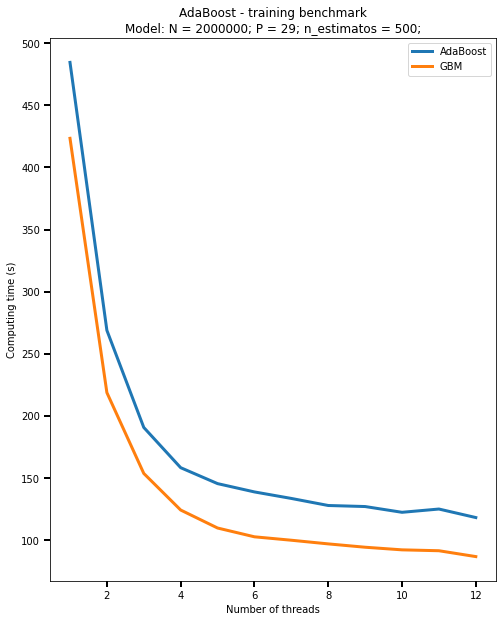

In [7]:
plot_result(adaboost_time, gbm_time)

In [8]:
adaboost_time, gbm_time = run_benchmark(prefix + "/bigdata/laptop/lending-club/loan.csv", "bad_loan")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu8djff23
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu8djff23\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu8djff23\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lvbr2b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.928358554840088s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.750338792800903s
H2O session _sid_a33e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_z6vu40x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_z6vu40x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_z6vu40x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bkzvns
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.079350471496582s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.5303428173065186s
H2O session _sid_b99f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa43r86wm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa43r86wm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa43r86wm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bs9vli
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.855988025665283s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.718262672424316s
H2O session _sid_8291 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplskab0v0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplskab0v0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplskab0v0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4mpkjr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.49164915084839s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.7631566524505615s
H2O session _sid_a573 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0l1bqfs8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0l1bqfs8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0l1bqfs8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rga3ep
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.65471124649048s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.903900146484375s
H2O session _sid_93ec closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe545etb8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe545etb8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe545etb8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ri5waw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.503549337387085s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.790182828903198s
H2O session _sid_8b30 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp667vmh2o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp667vmh2o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp667vmh2o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6e6gbq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.907583236694336s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.854912996292114s
H2O session _sid_b6aa closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpitxqona6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpitxqona6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpitxqona6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_apediu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.079773426055908s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.138096570968628s
H2O session _sid_941d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgu83p2y8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgu83p2y8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgu83p2y8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_w49ybp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.438481092453003s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.488645553588867s
H2O session _sid_9532 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv78ctd7g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv78ctd7g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv78ctd7g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nl9qet
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.89656925201416s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.485093355178833s
H2O session _sid_8264 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsp3xciut
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsp3xciut\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsp3xciut\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_akt9ib
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.869433641433716s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.196409702301025s
H2O session _sid_8f2b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgx9r01gd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgx9r01gd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgx9r01gd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_a02oay
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.076775550842285s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.629184246063232s
H2O session _sid_9346 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1m4sikhx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1m4sikhx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1m4sikhx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7f2h4k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.963093280792236s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.977071285247803s
H2O session _sid_a30f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptt939w21
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptt939w21\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptt939w21\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_th2oz5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.09271264076233s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.305181264877319s
H2O session _sid_91a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_y0jfm82
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_y0jfm82\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_y0jfm82\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3gxen7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.399043560028076s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.808028936386108s
H2O session _sid_a464 closed.
AdaBoost 19.149138164520263s
IF 6.555920521418254s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxy2h02bl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxy2h02bl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxy2h02bl\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ymbl7q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.333571195602417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.413380146026611s
H2O session _sid_8d08 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg7sd19in
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg7sd19in\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg7sd19in\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gwdqhw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.218077182769775s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.248642921447754s
H2O session _sid_beaa closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkvtatwre
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkvtatwre\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkvtatwre\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_41eo1y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.211320877075195s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.231016159057617s
H2O session _sid_8293 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3e8b2i_5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3e8b2i_5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3e8b2i_5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dfafkp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.090715169906616s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.531094789505005s
H2O session _sid_bb71 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphz31vslf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphz31vslf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphz31vslf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mmm32n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.954808712005615s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.263682842254639s
H2O session _sid_b8de closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvtear88z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvtear88z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvtear88z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3d0amq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.858041048049927s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.4940783977508545s
H2O session _sid_bd26 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpas16ap_h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpas16ap_h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpas16ap_h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vpxhbz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.092512607574463s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.19553279876709s
H2O session _sid_8058 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj87x7tv6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj87x7tv6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj87x7tv6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ftkdz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.63706350326538s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.524294137954712s
H2O session _sid_a719 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9fwz5jtd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9fwz5jtd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9fwz5jtd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6tm30h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.717795610427856s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.198319435119629s
H2O session _sid_80db closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu07jttlh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu07jttlh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu07jttlh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lg2bzd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.151060342788696s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.281874179840088s
H2O session _sid_98d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp10h3v6_1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp10h3v6_1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp10h3v6_1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uj1q2m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.87427306175232s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.24526834487915s
H2O session _sid_a65c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp66d8t2m6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp66d8t2m6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp66d8t2m6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_q9hq4m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.113727569580078s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.298804998397827s
H2O session _sid_a1e4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb9qhgc6e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb9qhgc6e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb9qhgc6e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6zba5o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.127742052078247s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.410738945007324s
H2O session _sid_b62a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkhb1y4iy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkhb1y4iy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkhb1y4iy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hzx3zd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.101682424545288s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.27837610244751s
H2O session _sid_afc0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp74oxkokw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp74oxkokw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp74oxkokw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uc9hvv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.313785552978516s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.513350009918213s
H2O session _sid_a456 closed.
AdaBoost 17.05307846069336s
IF 5.408563613891602s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp52rltqr0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp52rltqr0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp52rltqr0\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mr765d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.0303635597229s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.19677734375s
H2O session _sid_8703 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4cxtg5gz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4cxtg5gz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4cxtg5gz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://1

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_45kvlr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.604027271270752s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.137570381164551s
H2O session _sid_85f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpneuyv_i1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpneuyv_i1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpneuyv_i1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mh6igz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.481470108032227s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.0585174560546875s
H2O session _sid_bffb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9_uedbey
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9_uedbey\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9_uedbey\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8yh5sp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.283052682876587s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.112494468688965s
H2O session _sid_af5a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmple59bl_t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmple59bl_t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmple59bl_t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mcdly1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.770779132843018s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.926327228546143s
H2O session _sid_a26b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqaurcsus
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqaurcsus\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqaurcsus\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_d1vyac
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.455320835113525s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.192390203475952s
H2O session _sid_88d3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_f7indl1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_f7indl1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_f7indl1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1et4g7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.345841646194458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.779479026794434s
H2O session _sid_9e64 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5ud33e3s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5ud33e3s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5ud33e3s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hikh7s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.542558908462524s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.59042763710022s
H2O session _sid_863a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcwo472_z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcwo472_z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcwo472_z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_246zaa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.512836456298828s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.773473739624023s
H2O session _sid_b6bd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptieo23g1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptieo23g1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptieo23g1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_h6ewto
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.556142568588257s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.0869081020355225s
H2O session _sid_972b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvgjdfhuf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvgjdfhuf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvgjdfhuf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_aczlk7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.977975606918335s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.342015981674194s
H2O session _sid_abad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjc_12pi_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjc_12pi_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjc_12pi_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nbmu6v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.031820058822632s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.488078355789185s
H2O session _sid_a870 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm694bamy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm694bamy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm694bamy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u4x5nl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.2965247631073s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.879926919937134s
H2O session _sid_8e37 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppruwx6c6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppruwx6c6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppruwx6c6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_s3a93p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.072924852371216s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.129685163497925s
H2O session _sid_8496 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_5rsji9e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_5rsji9e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_5rsji9e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_w39cvn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.652275800704956s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.931316137313843s
H2O session _sid_8d38 closed.
AdaBoost 16.307594283421835s
IF 5.308359209696452s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyc6ywrpe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyc6ywrpe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyc6ywrpe\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_yuz1xk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.50249981880188s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.560128211975098s
H2O session _sid_97b9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq1k1lswb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq1k1lswb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq1k1lswb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gp4sdh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.13730239868164s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.088545560836792s
H2O session _sid_b60f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz3b_tb0n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz3b_tb0n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz3b_tb0n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6003a5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.389504671096802s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.11713981628418s
H2O session _sid_9d52 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpls6xo87p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpls6xo87p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpls6xo87p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_th9sqp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.644519329071045s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.4189653396606445s
H2O session _sid_9db0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9zm9n103
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9zm9n103\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9zm9n103\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xoigpe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.67151689529419s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.096627712249756s
H2O session _sid_ba00 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq955jhdt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq955jhdt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq955jhdt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qvb8ti
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.298617362976074s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.5897088050842285s
H2O session _sid_a804 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnqaew_93
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnqaew_93\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnqaew_93\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_prt21i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.361421585083008s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.097056865692139s
H2O session _sid_9a6c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp504ljwf7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp504ljwf7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp504ljwf7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qar4l2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.485997438430786s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.811474084854126s
H2O session _sid_b1db closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_zfa6uwm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_zfa6uwm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_zfa6uwm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_y1m08b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.624128103256226s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.910314321517944s
H2O session _sid_bdcd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphx7p8_16
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphx7p8_16\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphx7p8_16\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_d03zap
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.425501346588135s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.961472988128662s
H2O session _sid_8087 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjuz89z60
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjuz89z60\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjuz89z60\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_q3m68q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 14.415070295333862s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.9269890785217285s
H2O session _sid_8967 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpahfw88q2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpahfw88q2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpahfw88q2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wiepix
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.28260850906372s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.058640718460083s
H2O session _sid_b64c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd54zegbi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd54zegbi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd54zegbi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lq4xnn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.48044991493225s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.009270906448364s
H2O session _sid_b303 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiim5knnw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiim5knnw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiim5knnw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_b2umfn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.784242630004883s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.052009344100952s
H2O session _sid_863c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptdmp0t06
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptdmp0t06\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptdmp0t06\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nl18zh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.649951934814453s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.037932634353638s
H2O session _sid_b29a closed.
AdaBoost 15.67688881556193s
IF 5.249085092544556s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgwla2umq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgwla2umq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgwla2umq\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4bnfw8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.51513934135437s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.441705703735352s
H2O session _sid_b788 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpddm3hlb9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpddm3hlb9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpddm3hlb9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xmog29
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.52306365966797s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.922597408294678s
H2O session _sid_b1d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp91tswcek
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp91tswcek\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp91tswcek\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_yoah3u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.606985569000244s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.456507921218872s
H2O session _sid_913d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyxxmrm_o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyxxmrm_o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyxxmrm_o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dfj4cs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.436505556106567s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.215952157974243s
H2O session _sid_9d6a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdlypc_96
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdlypc_96\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdlypc_96\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gcliz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.951722383499146s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.772388696670532s
H2O session _sid_87d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_8pn0puu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_8pn0puu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_8pn0puu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_e92xgx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.572779417037964s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.863866567611694s
H2O session _sid_ae51 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph6hrvs9t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph6hrvs9t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph6hrvs9t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4dwg5a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.711800575256348s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.9848103523254395s
H2O session _sid_b96f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx8fl0ocd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx8fl0ocd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx8fl0ocd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3d2ygc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.617989778518677s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.05516505241394s
H2O session _sid_a9b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxf5p72oj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxf5p72oj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxf5p72oj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zja777
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.699482917785645s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.938700914382935s
H2O session _sid_b41b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmmj6fmjb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmmj6fmjb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmmj6fmjb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8fl63v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.155125856399536s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.796182870864868s
H2O session _sid_9f11 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4ze0g08o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4ze0g08o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4ze0g08o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vp3895
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.58342432975769s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.756941318511963s
H2O session _sid_870c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyb8uazmv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyb8uazmv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyb8uazmv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3asq4w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.122022151947021s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.795796871185303s
H2O session _sid_9d97 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpess5hst0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpess5hst0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpess5hst0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_q2iyhw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.017380237579346s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.914185047149658s
H2O session _sid_8e0f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7bzqlljc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7bzqlljc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7bzqlljc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_nt37oy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.47089171409607s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.767945051193237s
H2O session _sid_8334 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa6luikfy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa6luikfy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa6luikfy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_qfzdkh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.31960105895996s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.934502840042114s
H2O session _sid_ac4b closed.
AdaBoost 15.886927636464437s
IF 5.374483251571656s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvgfs2pdp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvgfs2pdp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvgfs2pdp\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_o1k745
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.563132762908936s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.869151592254639s
H2O session _sid_896b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8xbszq54
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8xbszq54\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8xbszq54\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_d9cx49
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.60060715675354s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.903323650360107s
H2O session _sid_9a12 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv1c3gjs7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv1c3gjs7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv1c3gjs7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_5d0jhz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.494080781936646s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.78747034072876s
H2O session _sid_b90c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuxidgr8v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuxidgr8v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuxidgr8v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_a7t8k6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.50173258781433s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.79610538482666s
H2O session _sid_8f62 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9vvwyyx9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9vvwyyx9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9vvwyyx9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_b4o7ou
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.540785312652588s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.011778831481934s
H2O session _sid_9abe closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbo6hsw28
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbo6hsw28\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbo6hsw28\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_dqn55v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 15.502268552780151s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.582482576370239s
H2O session _sid_9a10 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgc89watk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgc89watk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgc89watk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_1kyu9r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.826544523239136s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.1374993324279785s
H2O session _sid_9c00 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_ntsbk1s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_ntsbk1s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_ntsbk1s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_re2frp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.808012008666992s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.8581862449646s
H2O session _sid_897b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp91o7yv7t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp91o7yv7t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp91o7yv7t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7gbk2u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.388383150100708s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.851451396942139s
H2O session _sid_99b9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2netxflw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2netxflw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2netxflw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_wto3mg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.4819495677948s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.779180288314819s
H2O session _sid_abed closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl0p2ojo5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl0p2ojo5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl0p2ojo5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_3bhsc9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.577723026275635s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.8012120723724365s
H2O session _sid_8403 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuxel67hs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuxel67hs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuxel67hs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_k8pr81
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.374999046325684s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.459923982620239s
H2O session _sid_bdf4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7ts1tikc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7ts1tikc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7ts1tikc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_cz67pd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.7083477973938s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.996471881866455s
H2O session _sid_8f71 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9ftln9nl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9ftln9nl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9ftln9nl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_hoqsfv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.5372154712677s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.726469993591309s
H2O session _sid_b192 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp954nc1ka
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp954nc1ka\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp954nc1ka\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ru98ur
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.46209144592285s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.8488359451293945s
H2O session _sid_8302 closed.
AdaBoost 17.224524879455565s
IF 5.960636234283447s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbffl5l8l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbffl5l8l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbffl5l8l\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_bv4ob2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.482131004333496s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.827936887741089s
H2O session _sid_9795 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptcogtjyg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptcogtjyg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptcogtjyg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_zd1wg2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.22830605506897s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.815770626068115s
H2O session _sid_9bb0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2f79tet0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2f79tet0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2f79tet0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_sfc4y1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.25214695930481s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.388969659805298s
H2O session _sid_9cc5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5r8lutvx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5r8lutvx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5r8lutvx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_9a74x7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.625903129577637s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.766155242919922s
H2O session _sid_8966 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp893vg724
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp893vg724\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp893vg724\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_uk6orh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.53368902206421s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.948241233825684s
H2O session _sid_8dbe closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjrhwqox1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjrhwqox1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjrhwqox1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_96ud10
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.73928666114807s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.936231851577759s
H2O session _sid_97a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwsz0n4qi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwsz0n4qi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwsz0n4qi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_k66nyp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.27997589111328s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.942072629928589s
H2O session _sid_bfc2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvt6yhtqk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvt6yhtqk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvt6yhtqk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_sqjiq2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.696250677108765s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.654770135879517s
H2O session _sid_8ac2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1vogcdcw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1vogcdcw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1vogcdcw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_2ov9bm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.003732442855835s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.821955442428589s
H2O session _sid_b38e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp4a8896x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp4a8896x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp4a8896x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_bu38sx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.113094329833984s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.9809205532073975s
H2O session _sid_b29f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdp1ulg7p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdp1ulg7p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdp1ulg7p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_34f9vk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.165594339370728s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.773660898208618s
H2O session _sid_b414 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn1j2uspi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn1j2uspi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn1j2uspi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ftk2ac
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.260632514953613s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.7638208866119385s
H2O session _sid_98c0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt_4tuf3n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt_4tuf3n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt_4tuf3n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_6c9q3k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.169483423233032s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.829820156097412s
H2O session _sid_b757 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5e6wdkr6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5e6wdkr6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5e6wdkr6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_pnrn0n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.226646661758423s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.943612813949585s
H2O session _sid_b54e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpme_s7jo8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpme_s7jo8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpme_s7jo8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rm1emb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.407525539398193s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.864144325256348s
H2O session _sid_ba0d closed.
AdaBoost 16.745626576741536s
IF 5.4838722229003904s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp16aym82c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp16aym82c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp16aym82c\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_zqxbkl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.586082935333252s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.790037155151367s
H2O session _sid_b7de closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfli7kf1a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfli7kf1a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfli7kf1a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_d0y2dk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.710644483566284s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.931826829910278s
H2O session _sid_8d38 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgmr1alpi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgmr1alpi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgmr1alpi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_nb5o92
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.642230987548828s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.761071443557739s
H2O session _sid_8734 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt440_ktp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt440_ktp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt440_ktp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_1lbfnz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.513875484466553s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.916500568389893s
H2O session _sid_83f4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpph_0p01t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpph_0p01t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpph_0p01t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_b9onbc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.50930690765381s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.8484721183776855s
H2O session _sid_8b18 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvaz912ov
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvaz912ov\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvaz912ov\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_z196kc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.51163959503174s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.020240783691406s
H2O session _sid_91e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuhhbvpmi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuhhbvpmi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuhhbvpmi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ivv6x5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.387981176376343s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.785568952560425s
H2O session _sid_9f39 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5jb35fs9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5jb35fs9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5jb35fs9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rqzacp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.4542453289032s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.799258470535278s
H2O session _sid_bb4b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg92nw9dy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg92nw9dy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg92nw9dy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_6gayzf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.608359336853027s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.855874061584473s
H2O session _sid_9688 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2ae0qmwg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2ae0qmwg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2ae0qmwg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ninndq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.69013214111328s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.787164926528931s
H2O session _sid_aa7b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm7kpq4uh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm7kpq4uh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm7kpq4uh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_t1elee
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.48753309249878s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.690507888793945s
H2O session _sid_8ee0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp38o1nj9k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp38o1nj9k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp38o1nj9k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ehz7sm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.514588832855225s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.398167371749878s
H2O session _sid_8ed2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk3c40t5y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk3c40t5y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk3c40t5y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_xj7ctu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.687264442443848s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.34549880027771s
H2O session _sid_bd5d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc_1wj_6k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc_1wj_6k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc_1wj_6k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_hypvuu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.56544852256775s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.827512741088867s
H2O session _sid_8733 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp12gmv8bd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp12gmv8bd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp12gmv8bd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_jp5kp8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.509906768798828s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.8116631507873535s
H2O session _sid_99fc closed.
AdaBoost 17.558616002400715s
IF 5.637957684199015s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgmdr2na4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgmdr2na4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgmdr2na4\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_4vj51v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.513761520385742s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.952015399932861s
H2O session _sid_b74b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptkzw7xre
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptkzw7xre\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptkzw7xre\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_bsbs56
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.377134323120117s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.7823326587677s
H2O session _sid_80fd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsuil3l64
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsuil3l64\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsuil3l64\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_pc2d41
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.66924476623535s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.745822429656982s
H2O session _sid_8722 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2c2gk24i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2c2gk24i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2c2gk24i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_uyommq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.25080943107605s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.7060706615448s
H2O session _sid_ad57 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm5zhrysi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm5zhrysi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm5zhrysi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_p6ckig
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.72848892211914s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.8296284675598145s
H2O session _sid_b8bf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzp_z3adf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzp_z3adf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzp_z3adf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_4retyy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.421550035476685s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.860635280609131s
H2O session _sid_9d1d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfs1r0f9y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfs1r0f9y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfs1r0f9y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_82xbw5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.262926816940308s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.89560866355896s
H2O session _sid_a712 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe0m38vkf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe0m38vkf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe0m38vkf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_zwiol6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.633626699447632s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.3240978717803955s
H2O session _sid_82bd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqw5550l0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqw5550l0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqw5550l0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ad797l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.634069681167603s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.881582975387573s
H2O session _sid_b2e0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppislfiv3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppislfiv3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppislfiv3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_72mv16
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.724600791931152s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.771300315856934s
H2O session _sid_ba62 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvtm9xbdy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvtm9xbdy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvtm9xbdy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_h7qx99
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.93909215927124s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.762428283691406s
H2O session _sid_9327 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppvt_qrte
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppvt_qrte\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppvt_qrte\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_x9cqk7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.685962677001953s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.895611047744751s
H2O session _sid_82ea closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_nguq1o4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_nguq1o4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_nguq1o4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_mehr57
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.922056436538696s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.849839925765991s
H2O session _sid_8710 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpywmkt58c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpywmkt58c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpywmkt58c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_nw2aht
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.222126007080078s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.79291558265686s
H2O session _sid_ac94 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa2cva429
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa2cva429\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa2cva429\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_6thog6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.76434016227722s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.94542384147644s
H2O session _sid_9fbf closed.
AdaBoost 18.649986028671265s
IF 5.9330208937327065s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv0lms801
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv0lms801\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv0lms801\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_tw4d0d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.91925835609436s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.449067115783691s
H2O session _sid_995d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwzqp4ui2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwzqp4ui2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwzqp4ui2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_s7xg9y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.80611252784729s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.9445271492004395s
H2O session _sid_b5b8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph7dzjlev
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph7dzjlev\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph7dzjlev\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ixy7nh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.86725902557373s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.049774408340454s
H2O session _sid_8d8c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvqv38zxr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvqv38zxr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvqv38zxr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_q8ak5v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.703416347503662s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.025501251220703s
H2O session _sid_94de closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx12mzzzn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx12mzzzn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx12mzzzn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rtgr6c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.862155199050903s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.982943296432495s
H2O session _sid_a5ce closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjzb9d4sh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjzb9d4sh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjzb9d4sh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_z794rm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 20.502155303955078s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.548980236053467s
H2O session _sid_8228 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2u_2rdhy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2u_2rdhy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2u_2rdhy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_fsid21
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.814937114715576s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.043018102645874s
H2O session _sid_a149 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3gp0yffj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3gp0yffj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3gp0yffj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_pxc0kg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 22.734092235565186s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.138174295425415s
H2O session _sid_b0b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2euozzbo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2euozzbo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2euozzbo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_eezme6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 22.215718984603882s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.150188684463501s
H2O session _sid_b749 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpte_6bgtf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpte_6bgtf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpte_6bgtf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_a0yb3x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.98587727546692s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.564042091369629s
H2O session _sid_a394 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3g9lp4vi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3g9lp4vi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3g9lp4vi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_a1jx9t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.856741428375244s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.9420552253723145s
H2O session _sid_aac2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu0biasna
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu0biasna\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu0biasna\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_cw6etb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.926090717315674s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.068353176116943s
H2O session _sid_ac29 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpea5ug4dp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpea5ug4dp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpea5ug4dp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_f2bc4g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.967999696731567s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.129186391830444s
H2O session _sid_bb10 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu7s0c9nb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu7s0c9nb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu7s0c9nb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_c9bhxd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.953598737716675s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.021409511566162s
H2O session _sid_ad04 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpogmqpapj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpogmqpapj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpogmqpapj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_9rhvu2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.917482137680054s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.556591033935547s
H2O session _sid_a693 closed.
AdaBoost 21.735526339213052s
IF 7.240920797983805s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt5reuxec
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt5reuxec\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt5reuxec\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_un13ey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.190489530563354s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.490822553634644s
H2O session _sid_96b6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy_7nn_3q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy_7nn_3q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy_7nn_3q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_76l53n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.375714778900146s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.2041175365448s
H2O session _sid_b0bd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsbl8msp3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsbl8msp3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsbl8msp3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ujz12g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.239253044128418s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.192270278930664s
H2O session _sid_a3fb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjmts521e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjmts521e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjmts521e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_b9bywh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.485733032226562s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.589887380599976s
H2O session _sid_bd3b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz9ldgl2o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz9ldgl2o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz9ldgl2o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8gc2l2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.393041610717773s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.71944284439087s
H2O session _sid_8d99 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8megbwlf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8megbwlf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8megbwlf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_mcygeg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.63613271713257s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.283019304275513s
H2O session _sid_a206 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr_nsle6a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr_nsle6a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr_nsle6a\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ruj0mu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.322351932525635s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.420637845993042s
H2O session _sid_af07 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprc3xeoxz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprc3xeoxz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprc3xeoxz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_3crfl6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.500335693359375s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.596119165420532s
H2O session _sid_b6ee closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl8sf3l2l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl8sf3l2l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl8sf3l2l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_hkutca
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.75170874595642s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.062469005584717s
H2O session _sid_9fdf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm3zmios7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm3zmios7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm3zmios7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_hxipsd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.469773769378662s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.351921081542969s
H2O session _sid_a69e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyx5o_pym
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyx5o_pym\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyx5o_pym\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_2qp58e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.36128282546997s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.400871753692627s
H2O session _sid_abf6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp25uwsyma
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp25uwsyma\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp25uwsyma\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_yqc89z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.69767141342163s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 10.008915901184082s
H2O session _sid_9eb0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprryy_57u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprryy_57u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprryy_57u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ppdw4f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.221031188964844s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.329901933670044s
H2O session _sid_9b63 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkr76zl19
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkr76zl19\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkr76zl19\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_3wicyf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.288066625595093s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.38699460029602s
H2O session _sid_ab85 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj3fdkh42
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj3fdkh42\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj3fdkh42\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_17hcow
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.238608837127686s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 9.312363147735596s
H2O session _sid_a07c closed.
AdaBoost 27.678079716364543s
IF 9.75665028889974s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaobduj7j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaobduj7j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaobduj7j\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_kxarti
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 43.99624252319336s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.56840205192566s
H2O session _sid_baf4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgoct624u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgoct624u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgoct624u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ncdk00
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 44.16140794754028s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.931824207305908s
H2O session _sid_b6f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm3sm1me9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm3sm1me9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm3sm1me9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_zw0w22
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 46.48850774765015s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.99740195274353s
H2O session _sid_8945 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvkb4blbf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvkb4blbf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvkb4blbf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_e1zlfh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.12415289878845s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.78720712661743s
H2O session _sid_a03f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7lir7xk0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7lir7xk0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7lir7xk0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_v1c47w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 48.837669372558594s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.84328603744507s
H2O session _sid_b201 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1os54dn9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1os54dn9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1os54dn9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_j1hn76
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 46.469380378723145s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.5636088848114s
H2O session _sid_afad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpit9fbx4o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpit9fbx4o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpit9fbx4o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_kdkfik
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 46.642932176589966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.745874881744385s
H2O session _sid_8f1f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgu9qaorz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgu9qaorz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgu9qaorz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_vbih8b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 46.629618406295776s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.736971855163574s
H2O session _sid_a05b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzeq_3ex6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzeq_3ex6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzeq_3ex6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_t2dd9c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 45.272456645965576s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.28637385368347s
H2O session _sid_8af6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmdki9ns0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmdki9ns0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmdki9ns0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_48axe9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 45.21826934814453s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.688463687896729s
H2O session _sid_98a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_hr634g5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_hr634g5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_hr634g5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_6bqhmk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 42.25833439826965s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.450016260147095s
H2O session _sid_8767 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu5ke6g1f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu5ke6g1f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu5ke6g1f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_lxplzy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 42.14401316642761s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.596363067626953s
H2O session _sid_ace9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2rw3_9_o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2rw3_9_o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2rw3_9_o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_551cqi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 45.61183714866638s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.722168207168579s
H2O session _sid_8859 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe4pu6s4b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe4pu6s4b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe4pu6s4b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_4i3c81
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 43.11426758766174s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.460456132888794s
H2O session _sid_a846 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvryl54ek
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvryl54ek\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvryl54ek\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_0kp3xh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 48.88957905769348s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.77628803253174s
H2O session _sid_adf4 closed.
AdaBoost 45.65724458694458s
IF 16.410313749313353s
12 - AdaBoost = 19.149138164520263, GBM = 6.555920521418254
11 - AdaBoost = 17.05307846069336, GBM = 5.408563613891602
10 - AdaBoost = 16.307594283421835, GBM = 5.308359209696452
9 - AdaBoost = 15.67688881556193, GBM = 5.249085092544556
8 - AdaBoost = 15.886927636464437, GBM = 5.374483251571656
7 - AdaBoost = 17.224524879455565, GBM = 5.960636234283447
6 - AdaBoost = 16.745626576741536, GBM = 5.4838722229003904
5 - AdaBoost = 17.558616002400715, GBM = 5.637957684199015
4 - AdaBoost = 18.649986028671265, GBM = 5.9330208937327065
3 - AdaBoost = 21.735526339213052, GB

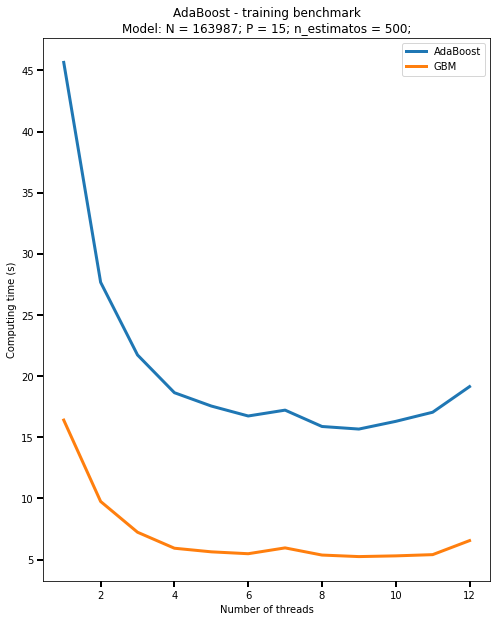

In [9]:
plot_result(adaboost_time, gbm_time)

In [10]:
adaboost_time, gbm_time = run_benchmark(prefix + "/bigdata/laptop/creditcardfraud/creditcardfraud.csv", "Class")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6q35w_31
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6q35w_31\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6q35w_31\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_p1d7r3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.62846350669861s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.848772287368774s
H2O session _sid_82dd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe1v6znj5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe1v6znj5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe1v6znj5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_if1bg0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.152509689331055s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.048713684082031s
H2O session _sid_be55 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2h_p0ple
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2h_p0ple\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2h_p0ple\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_vz9m7m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 32.266911029815674s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.363844871520996s
H2O session _sid_90f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo__3n1o9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo__3n1o9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo__3n1o9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_mqaf2e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.622547388076782s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.180207014083862s
H2O session _sid_be50 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1zr5eb9p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1zr5eb9p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1zr5eb9p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8e0d42
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.997031688690186s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.13716983795166s
H2O session _sid_abb2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppvm547th
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppvm547th\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppvm547th\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_bat977
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.788641452789307s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.766114234924316s
H2O session _sid_ad61 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1uevf0og
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1uevf0og\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1uevf0og\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_g4ftby
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.494526386260986s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.3516628742218s
H2O session _sid_aad3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp824g4bc0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp824g4bc0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp824g4bc0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_12kz2f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.215115785598755s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.197081565856934s
H2O session _sid_96dd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoaj_yd84
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoaj_yd84\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoaj_yd84\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_iflbtw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.028864860534668s
gbm Model Build progress: |████████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.065025329589844s
H2O session _sid_b0e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0l63r9zx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0l63r9zx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0l63r9zx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_5g0634
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.603529691696167s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.09284210205078s
H2O session _sid_8284 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd1nq_z2m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd1nq_z2m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd1nq_z2m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_x1w3n1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.622755527496338s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.8717679977417s
H2O session _sid_9b09 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy_r8vj5e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy_r8vj5e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy_r8vj5e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_19dmgb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 33.28302359580994s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.768521785736084s
H2O session _sid_9fc7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_uk_efr8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_uk_efr8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_uk_efr8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_gjuk5g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.616711854934692s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.07688283920288s
H2O session _sid_929b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpla5y8nja
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpla5y8nja\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpla5y8nja\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_debv8j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.43690276145935s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.261255025863647s
H2O session _sid_8e43 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphs28jrq2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphs28jrq2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphs28jrq2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7xkb1h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.76579713821411s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.10824751853943s
H2O session _sid_9f61 closed.
AdaBoost 30.501555490493775s
IF 15.475873931248982s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphclt2eyt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphclt2eyt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphclt2eyt\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_lvi3oq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.241512537002563s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.26199197769165s
H2O session _sid_881e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0e024fd0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0e024fd0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0e024fd0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_a464d6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.214337587356567s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.592419385910034s
H2O session _sid_8339 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5tjqgs8i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5tjqgs8i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5tjqgs8i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_0xesds
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.79670548439026s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.56148600578308s
H2O session _sid_a605 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk9c8moez
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk9c8moez\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk9c8moez\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_leeihd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.088322401046753s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.84347939491272s
H2O session _sid_994e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6enwrs_r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6enwrs_r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6enwrs_r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_v7feo7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.51588010787964s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.37675714492798s
H2O session _sid_95e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6rznq5jc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6rznq5jc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6rznq5jc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_prq1pr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.756505966186523s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.61621904373169s
H2O session _sid_8e2c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsn6yxbfv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsn6yxbfv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsn6yxbfv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_yo2yh8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.772697925567627s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.316792249679565s
H2O session _sid_affa closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp05in7bpv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp05in7bpv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp05in7bpv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ifr8xb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.343626022338867s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.68463659286499s
H2O session _sid_a4a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4hdxb8yg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4hdxb8yg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4hdxb8yg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7w7vz6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.43082094192505s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.432296752929688s
H2O session _sid_b6ab closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9h2xeu3z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9h2xeu3z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9h2xeu3z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_m1zwgc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.549785614013672s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.932926177978516s
H2O session _sid_8a55 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzix05b4m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzix05b4m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzix05b4m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8z8t1g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.87099266052246s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.356390953063965s
H2O session _sid_8627 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4rx0qf2x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4rx0qf2x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4rx0qf2x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_5p49ej
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.33463740348816s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.27663803100586s
H2O session _sid_950e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp73seymdj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp73seymdj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp73seymdj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_278f9m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.348203659057617s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.833583354949951s
H2O session _sid_9813 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7povca87
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7povca87\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7povca87\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_fj51am
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.417755842208862s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.46303677558899s
H2O session _sid_ba4d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp47iq5_t8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp47iq5_t8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp47iq5_t8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_fhnxry
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.70348048210144s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.471349239349365s
H2O session _sid_aa37 closed.
AdaBoost 27.225684309005736s
IF 15.201333538691204s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyco8hmdn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyco8hmdn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyco8hmdn\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rzxbgs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.73992919921875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.903725862503052s
H2O session _sid_9c4e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4wf6yydj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4wf6yydj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4wf6yydj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_dk9ulb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.669847011566162s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.782450914382935s
H2O session _sid_8637 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmre3vgak
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmre3vgak\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmre3vgak\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_uy99ai
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.180048942565918s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.81008791923523s
H2O session _sid_a203 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo1c7wp_i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo1c7wp_i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo1c7wp_i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7r62us
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 24.94692611694336s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.94797658920288s
H2O session _sid_aedb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqyx81n3c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqyx81n3c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqyx81n3c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_avfl7b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 24.705121517181396s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.798125267028809s
H2O session _sid_b5b4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp62ur4li4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp62ur4li4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp62ur4li4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_g4kvb8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.61112332344055s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.068406105041504s
H2O session _sid_916d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy45tyre3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy45tyre3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy45tyre3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_unm4hk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.09713912010193s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.92444133758545s
H2O session _sid_b216 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt4k4s0al
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt4k4s0al\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt4k4s0al\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_iliv8b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.10731530189514s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.793561697006226s
H2O session _sid_a52c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplsbl9qix
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplsbl9qix\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplsbl9qix\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_anotog
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.39767289161682s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.505964279174805s
H2O session _sid_9d30 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgp63u3_l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgp63u3_l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgp63u3_l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_84zzuu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.46159553527832s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.936924695968628s
H2O session _sid_9a12 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8ohxxfh2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8ohxxfh2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8ohxxfh2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_msbu2c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.057074308395386s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.219433307647705s
H2O session _sid_b69c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv_jaaxrd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv_jaaxrd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv_jaaxrd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ccwypy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.3142306804657s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.409417390823364s
H2O session _sid_83b2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplxipmwnj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplxipmwnj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplxipmwnj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_oray06
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.423810720443726s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.981651544570923s
H2O session _sid_ae1d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp298eg9qb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp298eg9qb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp298eg9qb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_lslhzj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.475086212158203s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.521393299102783s
H2O session _sid_98e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp21dx4jgd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp21dx4jgd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp21dx4jgd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_35evan
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.065669298171997s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.069153785705566s
H2O session _sid_a09c closed.
AdaBoost 26.816839345296223s
IF 15.578180932998658s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4x11zuh2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4x11zuh2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4x11zuh2\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_w8q9vk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.624071836471558s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.035494565963745s
H2O session _sid_8a7e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaju2u7gg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaju2u7gg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaju2u7gg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_yrxyr0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 24.699230670928955s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.926158905029297s
H2O session _sid_8270 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprnq0362w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprnq0362w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprnq0362w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_darzf1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.493425369262695s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.847246885299683s
H2O session _sid_95a9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8e7y0opk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8e7y0opk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8e7y0opk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7jroo7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.779715538024902s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.00390887260437s
H2O session _sid_8730 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp61us_w9y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp61us_w9y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp61us_w9y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_q3r88s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.42462658882141s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.101625204086304s
H2O session _sid_88e2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7mid80nj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7mid80nj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7mid80nj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_gj1yxb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.857666969299316s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.201035022735596s
H2O session _sid_8abf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp55h3z1mp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp55h3z1mp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp55h3z1mp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_e1ontj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.02292513847351s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.84868550300598s
H2O session _sid_a441 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp283bbn_e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp283bbn_e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp283bbn_e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_w2gvzz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.52606225013733s
gbm Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.836513996124268s
H2O session _sid_8301 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmclkcn4x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmclkcn4x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmclkcn4x\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_005ltv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.111430406570435s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.9427433013916s
H2O session _sid_9ce0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjf7cw2j5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjf7cw2j5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjf7cw2j5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_0gj8gs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.9047589302063s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.152506589889526s
H2O session _sid_8758 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf6mbrjxp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf6mbrjxp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf6mbrjxp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_f1ew1u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.7105975151062s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.066158533096313s
H2O session _sid_b28b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6fo0dk7r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6fo0dk7r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6fo0dk7r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_abgr7f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.705142498016357s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.012621879577637s
H2O session _sid_a56a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgjz109un
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgjz109un\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgjz109un\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_dlhxp8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.466447114944458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.937400341033936s
H2O session _sid_b9db closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpay75q9m6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpay75q9m6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpay75q9m6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_k1s8uo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.377819061279297s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.2928946018219s
H2O session _sid_b64d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg56_czge
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg56_czge\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg56_czge\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_9w98nb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,9
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 24.82416081428528s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.051197052001953s
H2O session _sid_8afa closed.
AdaBoost 26.835205380121867s
IF 16.083746083577473s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt9ih7fi9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt9ih7fi9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt9ih7fi9\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_4terre
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.4928457736969s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.044974327087402s
H2O session _sid_ad9a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps9awu2c1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps9awu2c1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps9awu2c1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_au48eh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.548491716384888s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.850628852844238s
H2O session _sid_8071 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprrd8hrxw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprrd8hrxw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprrd8hrxw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_xd7k8o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.21009087562561s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.63102102279663s
H2O session _sid_a3ce closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptqerh827
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptqerh827\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptqerh827\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_3e0j9z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.305715322494507s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.762624979019165s
H2O session _sid_8db2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu7p4ehw6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu7p4ehw6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu7p4ehw6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ychdj3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.351003885269165s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.627985954284668s
H2O session _sid_a0a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphof_a05q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphof_a05q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphof_a05q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_z7l0ja
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.31575345993042s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.177716493606567s
H2O session _sid_abc3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm56y78cr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm56y78cr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm56y78cr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_bylay0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.335508108139038s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.48555064201355s
H2O session _sid_b9e3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpga18v7mv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpga18v7mv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpga18v7mv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8bm9uc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.720674514770508s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.15843939781189s
H2O session _sid_9c99 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi8zmvznd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi8zmvznd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi8zmvznd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_02lc3e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.753278493881226s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.955356121063232s
H2O session _sid_8825 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2mjmcz2c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2mjmcz2c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2mjmcz2c\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7pnrd4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.8377947807312s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 18.21028470993042s
H2O session _sid_bf09 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_kmagq1n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_kmagq1n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_kmagq1n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_n2miwa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.614968061447144s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.04213786125183s
H2O session _sid_81e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp15jvl_6r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp15jvl_6r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp15jvl_6r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_plnhzw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.899763822555542s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.071608304977417s
H2O session _sid_8166 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9c1narki
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9c1narki\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9c1narki\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_b4idvu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.686699628829956s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.11179280281067s
H2O session _sid_a562 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq9tu2xtu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq9tu2xtu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq9tu2xtu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_0hwurd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.265838861465454s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.879936218261719s
H2O session _sid_84c4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6eyrklml
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6eyrklml\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6eyrklml\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_osgw3z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.40771746635437s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.737633228302002s
H2O session _sid_878a closed.
AdaBoost 27.316409651438395s
IF 16.64984606107076s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpllczqf3k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpllczqf3k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpllczqf3k\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_jkne91
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.81390643119812s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.899618864059448s
H2O session _sid_9cb0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpusn1eud1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpusn1eud1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpusn1eud1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ar1l51
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.58285093307495s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.952778100967407s
H2O session _sid_aa0f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw3v4u6h0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw3v4u6h0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw3v4u6h0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_nlfq70
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.404147624969482s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.10560178756714s
H2O session _sid_b24d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg2jl3ezx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg2jl3ezx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg2jl3ezx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_56aq8n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.366334438323975s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.831589937210083s
H2O session _sid_b925 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplqxs6e_k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplqxs6e_k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplqxs6e_k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_fzhcka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.679290294647217s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.06168842315674s
H2O session _sid_83e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz2ueq435
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz2ueq435\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz2ueq435\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rfk6go
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.36591076850891s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.996016025543213s
H2O session _sid_b401 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfby6pmtn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfby6pmtn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfby6pmtn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_kiy9np
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.397974491119385s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.840975284576416s
H2O session _sid_8a0e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplqnmaom5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplqnmaom5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplqnmaom5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_o4zvgj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 25.357529401779175s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.912191390991211s
H2O session _sid_ab2c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdte1_xx9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdte1_xx9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdte1_xx9\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_d2lf7y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.814931869506836s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.789331674575806s
H2O session _sid_81b9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8vhymk86
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8vhymk86\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8vhymk86\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ig2unq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.2422091960907s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.848894834518433s
H2O session _sid_9719 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj_x87_7k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj_x87_7k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj_x87_7k\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_decc8l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 26.408717393875122s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.818611860275269s
H2O session _sid_9672 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp49ivl1y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp49ivl1y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp49ivl1y\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ex26pl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.38062334060669s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.281069040298462s
H2O session _sid_bab5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpreueea3s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpreueea3s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpreueea3s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_qym7uy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.2984561920166s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.83145761489868s
H2O session _sid_b7f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdcpzeiez
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdcpzeiez\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdcpzeiez\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_s5irje
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.62318181991577s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.821334838867188s
H2O session _sid_949f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxszsj_lg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxszsj_lg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxszsj_lg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rv0ubi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.62216877937317s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.804183959960938s
H2O session _sid_81af closed.
AdaBoost 27.157215531667074s
IF 16.519689575831094s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp2x0q_lu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp2x0q_lu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp2x0q_lu\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_57t1nd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.59929347038269s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 18.185187339782715s
H2O session _sid_b323 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx5j0n75n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx5j0n75n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx5j0n75n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_r347cm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.875866413116455s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.482953786849976s
H2O session _sid_b1d5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9og9_9zf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9og9_9zf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9og9_9zf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7ymjf5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.841585636138916s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 18.877108335494995s
H2O session _sid_a5a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4yruavqi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4yruavqi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4yruavqi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_u54v4o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.741172075271606s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.19967269897461s
H2O session _sid_a175 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpokg0rk6v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpokg0rk6v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpokg0rk6v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_eo0kj7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.333799123764038s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.117689609527588s
H2O session _sid_9750 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcfwud3gv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcfwud3gv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcfwud3gv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_qbmgqw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.457728147506714s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.01049304008484s
H2O session _sid_8226 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1mltisxm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1mltisxm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1mltisxm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_6jr4ft
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.52453374862671s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.85293698310852s
H2O session _sid_bf9b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1zstkhif
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1zstkhif\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1zstkhif\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_6t1br6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 27.458311557769775s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.7583909034729s
H2O session _sid_a306 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3z5e_95r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3z5e_95r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3z5e_95r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_hvraro
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.526652336120605s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.145129919052124s
H2O session _sid_bea6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoverbzld
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoverbzld\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoverbzld\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_o3qx8i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.709418058395386s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 18.279924154281616s
H2O session _sid_a138 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx0cs0ud3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx0cs0ud3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx0cs0ud3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_b1v7vd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.911869525909424s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 18.7741756439209s
H2O session _sid_9dcf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuzrptqrb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuzrptqrb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuzrptqrb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_pf2g1b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.91647243499756s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 18.270290851593018s
H2O session _sid_92d1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplma1zz60
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplma1zz60\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplma1zz60\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_fkwswy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.654130458831787s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 18.140315294265747s
H2O session _sid_9084 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprvupanf8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprvupanf8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprvupanf8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_tzoftu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.609302282333374s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 18.20269751548767s
H2O session _sid_802c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8849v9ve
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8849v9ve\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8849v9ve\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_o4vc1r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.711902141571045s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.076185941696167s
H2O session _sid_baf9 closed.
AdaBoost 29.858135827382405s
IF 18.158210134506227s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb8opyb0f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb8opyb0f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb8opyb0f\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_1fvf37
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.714895009994507s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.36753559112549s
H2O session _sid_93b6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6qn8q6yn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6qn8q6yn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6qn8q6yn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_vvh2by
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.428954362869263s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.80306100845337s
H2O session _sid_a3e9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprhffa0yg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprhffa0yg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprhffa0yg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rm1lih
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 28.551531553268433s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.837968111038208s
H2O session _sid_9592 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp57gbswez
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp57gbswez\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp57gbswez\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_adlg21
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.730571508407593s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.082119464874268s
H2O session _sid_a5bb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgaxwax7o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgaxwax7o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgaxwax7o\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rkb4ka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 29.850353002548218s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.14592695236206s
H2O session _sid_b0bc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9vwef2bt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9vwef2bt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9vwef2bt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_6wrwui
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 33.20039629936218s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.18355131149292s
H2O session _sid_adab closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu8ju4jit
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu8ju4jit\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu8ju4jit\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ao661x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 32.173463582992554s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.364304542541504s
H2O session _sid_b001 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5ebjkspq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5ebjkspq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5ebjkspq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_qppnfm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.11278247833252s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.59946298599243s
H2O session _sid_bf31 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa_0wtl6g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa_0wtl6g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa_0wtl6g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_nltz33
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.201242685317993s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.21744394302368s
H2O session _sid_aa33 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3w6nobdv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3w6nobdv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3w6nobdv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_xmmese
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 32.89763116836548s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.103536367416382s
H2O session _sid_935b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppoy7kvvo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppoy7kvvo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppoy7kvvo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_p4m3up
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 32.78375506401062s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.265501737594604s
H2O session _sid_a863 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp_c7sqx1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp_c7sqx1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp_c7sqx1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_to4bs5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 32.03331708908081s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.22494339942932s
H2O session _sid_b97f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeomfvih6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeomfvih6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeomfvih6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_jcl8gc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.818135261535645s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 17.79954695701599s
H2O session _sid_98d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppwwicjlr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppwwicjlr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppwwicjlr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_jzugvu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 32.962544202804565s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.01596426963806s
H2O session _sid_a297 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpimnvl_31
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpimnvl_31\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpimnvl_31\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_dlcr65
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.98521137237549s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 19.326138734817505s
H2O session _sid_9b55 closed.
AdaBoost 31.29631897608439s
IF 18.88913369178772s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp519fhfda
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp519fhfda\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp519fhfda\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_s5kdis
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 34.0802686214447s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 22.324602365493774s
H2O session _sid_885f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpajw6_7ml
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpajw6_7ml\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpajw6_7ml\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_vzd5t3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 34.17414903640747s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 21.569037199020386s
H2O session _sid_9d8d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpztbuz3g6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpztbuz3g6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpztbuz3g6\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_dpkg7s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 34.30544447898865s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 21.5185329914093s
H2O session _sid_a95a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpch71xgql
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpch71xgql\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpch71xgql\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_45nsjm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 33.93294954299927s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 21.65096640586853s
H2O session _sid_b6ad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6i47x453
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6i47x453\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6i47x453\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_x3jc7p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 33.82883954048157s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 21.31074047088623s
H2O session _sid_aca2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphfwf1gb4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphfwf1gb4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphfwf1gb4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8jiqq4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.771112203598022s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.303808212280273s
H2O session _sid_b135 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpww1y7_65
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpww1y7_65\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpww1y7_65\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_t1izl8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.834481716156006s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.053941249847412s
H2O session _sid_8958 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsx1b80o5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsx1b80o5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsx1b80o5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_wd4tkj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.956287622451782s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.130861043930054s
H2O session _sid_967e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo52pev0g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo52pev0g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo52pev0g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_cnkcx8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.818386554718018s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.296082019805908s
H2O session _sid_8731 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppupxwqwq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppupxwqwq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppupxwqwq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_1bhep0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.774044275283813s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.072088956832886s
H2O session _sid_b3ac closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4mfn2zci
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4mfn2zci\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4mfn2zci\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_xgepg4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 32.01339292526245s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.193058490753174s
H2O session _sid_9c23 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3z1rbecn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3z1rbecn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3z1rbecn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_vuzsa9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 32.09518909454346s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 20.154937505722046s
H2O session _sid_b485 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8ai1icsn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8ai1icsn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8ai1icsn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_go48ag
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 36.565690755844116s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 21.596691846847534s
H2O session _sid_81b1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk2m250yh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk2m250yh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk2m250yh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_6ok8hn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 33.378029108047485s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 22.40871524810791s
H2O session _sid_8a10 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8n98kl_7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8n98kl_7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8n98kl_7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_wu102i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 33.21884632110596s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 21.537135124206543s
H2O session _sid_8bbb closed.
AdaBoost 33.116474119822186s
IF 21.008079942067464s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa8xv06lm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa8xv06lm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa8xv06lm\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_73stqy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.04185962677002s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 26.070109844207764s
H2O session _sid_b407 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4mk8ph0b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4mk8ph0b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4mk8ph0b\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_9jspb9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 38.71722102165222s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 26.03186869621277s
H2O session _sid_84a5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdsnmjers
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdsnmjers\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdsnmjers\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_fikha0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.818615198135376s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 25.90511965751648s
H2O session _sid_a694 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7g_rdgc4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7g_rdgc4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7g_rdgc4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_g6ar7i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 38.61298942565918s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 25.811127185821533s
H2O session _sid_901f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnv5n99wg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnv5n99wg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnv5n99wg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8dn7v2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.348796129226685s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 28.30018925666809s
H2O session _sid_abac closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxwe2wnfz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxwe2wnfz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxwe2wnfz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_vntr76
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.906763553619385s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 25.962660551071167s
H2O session _sid_b107 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1m1g_ez0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1m1g_ez0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1m1g_ez0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7z1y3l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.91086268424988s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 26.688308000564575s
H2O session _sid_ad79 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0mutgtlt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0mutgtlt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0mutgtlt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_hgd37w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 41.26815676689148s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 26.822724103927612s
H2O session _sid_9c91 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5z46p7zy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5z46p7zy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5z46p7zy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_t088gf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.734562397003174s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 26.749467611312866s
H2O session _sid_9e17 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmportb9lmu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmportb9lmu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmportb9lmu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_jlam6b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 38.69564366340637s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 26.8009033203125s
H2O session _sid_bab2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfljha25n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfljha25n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfljha25n\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7ut46p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 39.903934955596924s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 24.95771598815918s
H2O session _sid_9c59 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp306phkx4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp306phkx4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp306phkx4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_mjngnc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 37.69237399101257s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 25.631564378738403s
H2O session _sid_9212 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjmlm5qm0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjmlm5qm0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjmlm5qm0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8zagyz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 37.6226282119751s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 24.82988214492798s
H2O session _sid_81a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4smrxuui
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4smrxuui\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4smrxuui\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_mphtq8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 37.18240785598755s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 24.899999141693115s
H2O session _sid_9087 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpptcieun2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpptcieun2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpptcieun2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_4lwna0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 37.530672550201416s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 24.716428756713867s
H2O session _sid_92dd closed.
AdaBoost 38.99916586875916s
IF 26.011871242523192s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdppuovic
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdppuovic\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdppuovic\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_olroad
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.750627517700195s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 35.85641074180603s
H2O session _sid_bf85 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmperqfqse4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmperqfqse4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmperqfqse4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_lyfltz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.86750411987305s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.27838611602783s
H2O session _sid_a1db closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm9j9s5mq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm9j9s5mq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm9j9s5mq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_6lzuye
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.1574923992157s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.26650905609131s
H2O session _sid_89d1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6d3y1wjb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6d3y1wjb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6d3y1wjb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7qf6qd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.18409776687622s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.06795930862427s
H2O session _sid_9ba8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsr_wagnd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsr_wagnd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsr_wagnd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ocp425
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.93767070770264s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.37753677368164s
H2O session _sid_bf62 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbm9jczqd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbm9jczqd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbm9jczqd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_aac7pp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.42858099937439s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.22200918197632s
H2O session _sid_847f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5769a67_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5769a67_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5769a67_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8ir7i2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.13536763191223s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 40.168741941452026s
H2O session _sid_bf2d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb2mt71uo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb2mt71uo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb2mt71uo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_aukplu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.2570161819458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.09706425666809s
H2O session _sid_9669 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkfrr23kt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkfrr23kt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkfrr23kt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_4yatah
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.00905156135559s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.9012713432312s
H2O session _sid_b0c9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7xaq4v0w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7xaq4v0w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7xaq4v0w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_0t0jxl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 51.93722891807556s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.36946368217468s
H2O session _sid_bb4b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplhe6352e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplhe6352e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplhe6352e\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_xtr498
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.18718504905701s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 37.46161890029907s
H2O session _sid_acba closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1mbd2vie
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1mbd2vie\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1mbd2vie\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7ftnk8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.961597204208374s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 36.31869554519653s
H2O session _sid_bfe9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj6bk4nlk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj6bk4nlk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj6bk4nlk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8cy3o8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.639374017715454s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 35.74886441230774s
H2O session _sid_be6f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa_unq0dr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa_unq0dr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa_unq0dr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_leytyz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.82249307632446s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 35.9676878452301s
H2O session _sid_9b4b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptzaly0fb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptzaly0fb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptzaly0fb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_tjmkbh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 49.92834424972534s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 35.87161588668823s
H2O session _sid_b235 closed.
AdaBoost 51.48024209340414s
IF 37.06492233276367s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjkfiwky8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjkfiwky8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjkfiwky8\h2o_potte_started_from_python.err
  Server is running at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_z3kqyz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 88.60113048553467s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 66.1678855419159s
H2O session _sid_ab89 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvow0g0dy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvow0g0dy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvow0g0dy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_4ma9kx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 91.54402351379395s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 71.60517692565918s
H2O session _sid_b582 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl8hdgd9t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl8hdgd9t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl8hdgd9t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_hluf0y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 92.18275213241577s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 70.7940514087677s
H2O session _sid_90f3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp31rl3frl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp31rl3frl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp31rl3frl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_vzxrjj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 91.04393982887268s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 71.05464839935303s
H2O session _sid_9796 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp17i4413z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp17i4413z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp17i4413z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_499qri
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 86.89155745506287s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 67.0130786895752s
H2O session _sid_a162 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphnjswkgp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphnjswkgp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphnjswkgp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_aqt5j5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 91.56162691116333s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 70.19714617729187s
H2O session _sid_8eb5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9j9_5vrp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9j9_5vrp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9j9_5vrp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_epwy6v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 91.40556335449219s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 71.48218584060669s
H2O session _sid_b232 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9fri95og
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9fri95og\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9fri95og\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_iz8h9g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 91.32101535797119s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 70.6900007724762s
H2O session _sid_b05f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpquw_jym0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpquw_jym0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpquw_jym0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_7fi39c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 90.41024875640869s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 69.79063844680786s
H2O session _sid_b7b7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5xptfvan
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5xptfvan\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5xptfvan\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_hasl5r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 87.75176358222961s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 69.22362732887268s
H2O session _sid_a8fa closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvcdq1x3f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvcdq1x3f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvcdq1x3f\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_zr954d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 88.26038002967834s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 72.02933168411255s
H2O session _sid_9aba closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8fzupvkx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8fzupvkx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8fzupvkx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_splsb3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 92.43140459060669s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 71.39526271820068s
H2O session _sid_b063 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkftdnbge
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkftdnbge\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkftdnbge\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_kso205
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 93.45610117912292s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 71.46152949333191s
H2O session _sid_b6ab closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsyqy4ix5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsyqy4ix5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsyqy4ix5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_r28mfs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 91.22825169563293s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 70.11266326904297s
H2O session _sid_bd85 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi_5saiyu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi_5saiyu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi_5saiyu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_zt4xnk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 90.04137516021729s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 71.60521125793457s
H2O session _sid_9560 closed.
AdaBoost 90.54207560221354s
IF 70.30816253026326s
12 - AdaBoost = 30.501555490493775, GBM = 15.475873931248982
11 - AdaBoost = 27.225684309005736, GBM = 15.201333538691204
10 - AdaBoost = 26.816839345296223, GBM = 15.578180932998658
9 - AdaBoost = 26.835205380121867, GBM = 16.083746083577473
8 - AdaBoost = 27.316409651438395, GBM = 16.64984606107076
7 - AdaBoost = 27.157215531667074, GBM = 16.519689575831094
6 - AdaBoost = 29.858135827382405, GBM = 18.158210134506227
5 - AdaBoost = 31.29631897608439, GBM = 18.88913369178772
4 - AdaBoost = 33.116474119822186, GBM = 21.008079942067464
3 - AdaBoost = 38.99916586875916

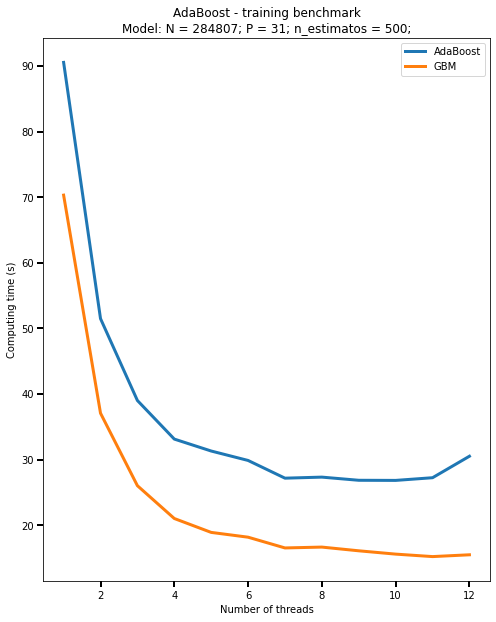

In [11]:
plot_result(adaboost_time, gbm_time)